# Topic Modelling Code

Imports

In [1]:
import nltk
import functools
import operator
import nltk
import itertools
import gdelt
from nltk.corpus import stopwords
from sklearn.manifold import TSNE
from scipy.spatial import distance
import scipy
from sklearn.neighbors import DistanceMetric
from scipy.spatial.distance import mahalanobis 
from sklearn.cluster import KMeans
from textblob import TextBlob
from sklearn.decomposition import PCA 
import matplotlib.pyplot as plt
from datetime import datetime
import wget
import requests
from sklearn.metrics.pairwise import euclidean_distances
import string
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
import string
import gensim
from gensim import corpora
from gensim.models.ldamodel import LdaModel
import numpy as np
import seaborn
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors
from collections import Counter
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
from matplotlib.colors import ListedColormap

Getting the single day data from the events table

In [2]:
gd2 = gdelt.gdelt(version=2)

In [3]:
results2 = gd2.Search(['2019 Nov 1'],table='events',coverage=True)
results2.head()

GLOBALEVENTID   SQLDATE  MonthYear  Year  FractionDate Actor1Code  \
0      883661268  20181101     201811  2018     2018.8247        NaN   
1      883661269  20181101     201811  2018     2018.8247        AUS   
2      883661270  20181101     201811  2018     2018.8247        CHN   
3      883661271  20181101     201811  2018     2018.8247        USA   
4      883661272  20181101     201811  2018     2018.8247        USA   

      Actor1Name Actor1CountryCode Actor1KnownGroupCode Actor1EthnicCode  ...  \
0            NaN               NaN                  NaN              NaN  ...   
1      AUSTRALIA               AUS                  NaN              NaN  ...   
2          CHINA               CHN                  NaN              NaN  ...   
3  UNITED STATES               USA                  NaN              NaN  ...   
4  UNITED STATES               USA                  NaN              NaN  ...   

  ActionGeo_Type                       ActionGeo_FullName  \
0              4                   Quebec, Quebec, Canada   
1              4                   Quebec, Quebec, Canada   
2              2                    Nevada, United States   
3              3  Merrill Hall, Washington, United States   
4              3  Merrill Hall, Washington, United States   

  ActionGeo_CountryCode ActionGeo_ADM1Code ActionGeo_ADM2Code ActionGeo_Lat  \
0                    CA               CA10              12750       47.5000   
1                    CA               CA10              12750       47.5000   
2                    US               USNV                NaN       38.4199   
3                    US               USWA                NaN       47.6579   
4                    US               USWA                NaN       47.6579   

  ActionGeo_Long ActionGeo_FeatureID       DATEADDED  \
0        -72.000             -571850  20191101023000   
1        -72.000             -571850  20191101023000   
2       -117.122                  NV  20191101023000   
3       -122.290             2461257  20191101023000   
4       -122.290             2461257  20191101023000   

                                           SOURCEURL  
0  https://www.washingtonpost.com/classic-apps/th...  
1  https://www.washingtonpost.com/classic-apps/th...  
2  http://europe.chinadaily.com.cn/a/201911/01/WS...  
3  https://theexonian.com/2019/10/31/sze-obyrne-e...  
4  https://theexonian.com/2019/10/31/sze-obyrne-e...  

[5 rows x 62 columns]

In [4]:
results2.columns

Index(['GLOBALEVENTID', 'SQLDATE', 'MonthYear', 'Year', 'FractionDate',
       'Actor1Code', 'Actor1Name', 'Actor1CountryCode', 'Actor1KnownGroupCode',
       'Actor1EthnicCode', 'Actor1Religion1Code', 'Actor1Religion2Code',
       'Actor1Type1Code', 'Actor1Type2Code', 'Actor1Type3Code', 'Actor2Code',
       'Actor2Name', 'Actor2CountryCode', 'Actor2KnownGroupCode',
       'Actor2EthnicCode', 'Actor2Religion1Code', 'Actor2Religion2Code',
       'Actor2Type1Code', 'Actor2Type2Code', 'Actor2Type3Code', 'IsRootEvent',
       'EventCode', 'CAMEOCodeDescription', 'EventBaseCode', 'EventRootCode',
       'QuadClass', 'GoldsteinScale', 'NumMentions', 'NumSources',
       'NumArticles', 'AvgTone', 'Actor1Geo_Type', 'Actor1Geo_FullName',
       'Actor1Geo_CountryCode', 'Actor1Geo_ADM1Code', 'Actor1Geo_ADM2Code',
       'Actor1Geo_Lat', 'Actor1Geo_Long', 'Actor1Geo_FeatureID',
       'Actor2Geo_Type', 'Actor2Geo_FullName', 'Actor2Geo_CountryCode',
       'Actor2Geo_ADM1Code', 'Actor2Geo_ADM2Code

This is the column from which the URL is retrieved

In [5]:
list_of_things = results2["SOURCEURL"]

In [6]:
list_of_things[0]

'https://www.nanaimobulletin.com/news/after-blackface-scandal-trudeau-shuns-photo-ops-of-trick-or-treating/'

## Stop Words

This is to split the urls, and remove "broken" URLs, which have "=" in them, and thus aren't headlines. The headline is assumed to be the last thing in the URL and is taken from there 

The stopwords are defined from the NLTK toolkit

In [2]:
stop_words = stopwords.words('english')

def x_split(x):
    if x.split("/")[-1] is None or x.split("/")[-1] == "" or "=" in x.split("/")[-1]:
        return x.split("/")[-2]
    return x.split("/")[-1]

# Filter Original Data

In [8]:
filt_list_of_things = [x_split(x).split("-") for x in list_of_things]

In [9]:
for n, sent in enumerate(filt_list_of_things):
    filt_list_of_things[n] = [x for x in filt_list_of_things[n] if x not in stop_words and x != ""]

filt_list_of_things = [x for x in filt_list_of_things if len(x) > 1]

In [10]:
length = len(filt_list_of_things)
length

129183

In [11]:
filt_list_of_things.sort()
final_list = list(k for k,_ in itertools.groupby(filt_list_of_things))

A simple count for the number of documents in the corpus a thing appears in

In [12]:
x=["iran", "war"]

In [13]:
def list_count(super_list, count_list):
    count = 0
    for sublist in super_list:
        if all(elem in sublist for elem in count_list):
            count = count + 1
    return count

In [14]:
list_count(final_list, x)

1

## Topic Model

If TF-IDF is run on single day's data -> memory errors

In [ ]:
vectorizer = TfidfVectorizer(use_idf=True,stop_words=stop_words)
vectors = vectorizer.fit_transform([" ".join(sub) for sub in filt_list_of_things])
feature_names = vectorizer.get_feature_names()
dense = vectors.todense()
denselist = dense.tolist()
df = pd.DataFrame(denselist, columns=feature_names)
new_df = df.transpose()
new_df.columns = ["TF/IDF"]
new_df.sort_values("TF/IDF", ascending=False)

### LDA Analysis

Data cleaning as required for one day's data

In [15]:
doc_complete = [x_split(x).replace("-", " ") for x in list_of_things if len(x.split("-")) >1]

In [16]:
stop = set(stopwords.words('english'))
exclude = set(string.punctuation) 
lemma = WordNetLemmatizer()
def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

doc_clean = [clean(doc).split() for doc in doc_complete]   

Make the dictionary term matrix

In [17]:
# make the term dictionary of the corpus, where every unique term is assigned an index. 
dictionary = corpora.Dictionary(doc_clean)

# Converting corpus into the Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]

In [18]:
dictionary 

Make a model with 3 topics 

In [19]:
ldamodel3 = LdaModel(doc_term_matrix, num_topics=3, id2word = dictionary, passes=50)

Look at the most common topics

In [20]:
ldamodel3.print_topics(num_topics=3, num_words=3)

[(0, '0.018*"11e9" + 0.008*"world" + 0.007*"pm"'),
 (1, '0.018*"trump" + 0.009*"new" + 0.008*"2019"'),
 (2, '0.011*"ar" + 0.010*"china" + 0.009*"u"')]

Plot the word cloud and word weights

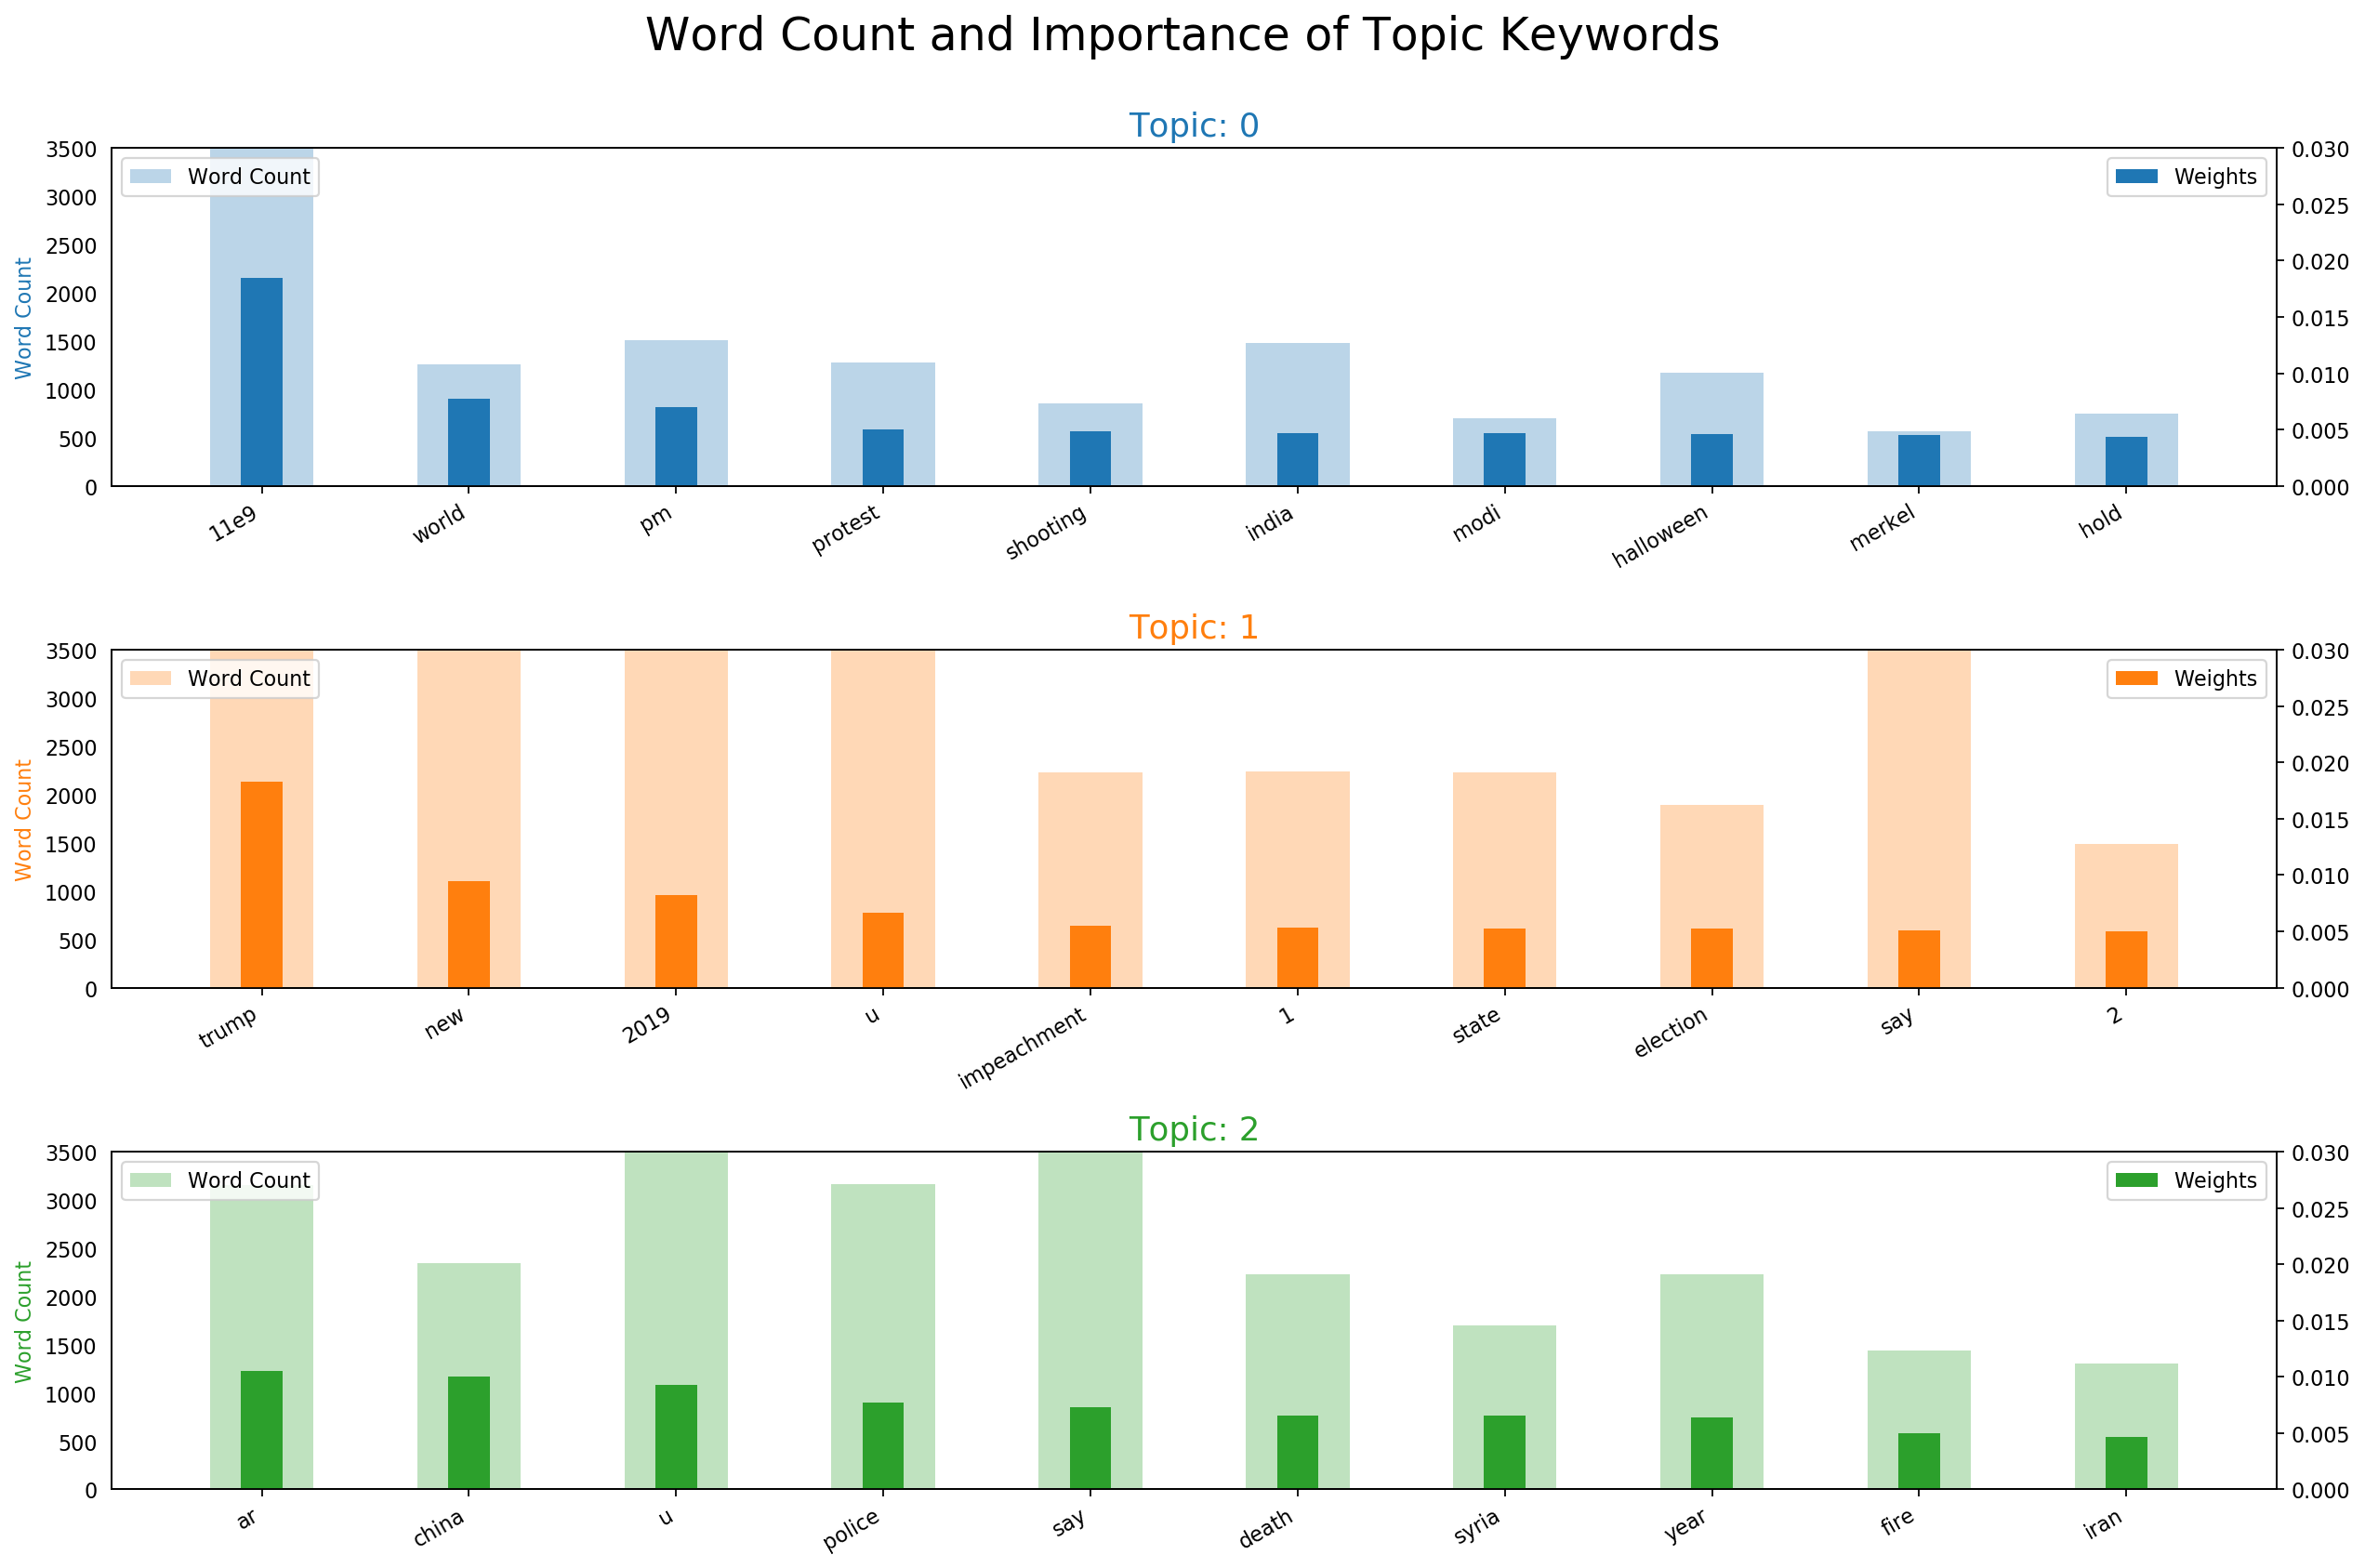

In [26]:
word_cloud(ldamodel3, 2, 2, "word_cloud_single_3_topics", del_x=1, del_y=1)
word_weight(ldamodel3, doc_clean, "word_weights_single_3_topics ", 3, 1)

Repeat the entire process for a 5 topic model, this uses the same dictionary as the previous stuff

In [27]:
%%time 
ldamodel5 = LdaModel(doc_term_matrix, num_topics=5, id2word = dictionary, passes=50)

CPU times: user 37min 14s, sys: 11.8 s, total: 37min 25s
Wall time: 37min 47s


In [28]:
ldamodel5.print_topics(num_topics=5, num_words=5)

[(0,
  '0.025*"11e9" + 0.011*"trump" + 0.011*"election" + 0.010*"world" + 0.008*"say"'),
 (1, '0.022*"ar" + 0.013*"2019" + 0.011*"news" + 0.010*"fire" + 0.010*"11"'),
 (2,
  '0.018*"new" + 0.014*"syria" + 0.009*"2020" + 0.009*"one" + 0.008*"turkey"'),
 (3,
  '0.013*"man" + 0.012*"year" + 0.011*"police" + 0.010*"death" + 0.008*"india"'),
 (4,
  '0.030*"u" + 0.021*"trump" + 0.014*"china" + 0.011*"impeachment" + 0.010*"state"')]

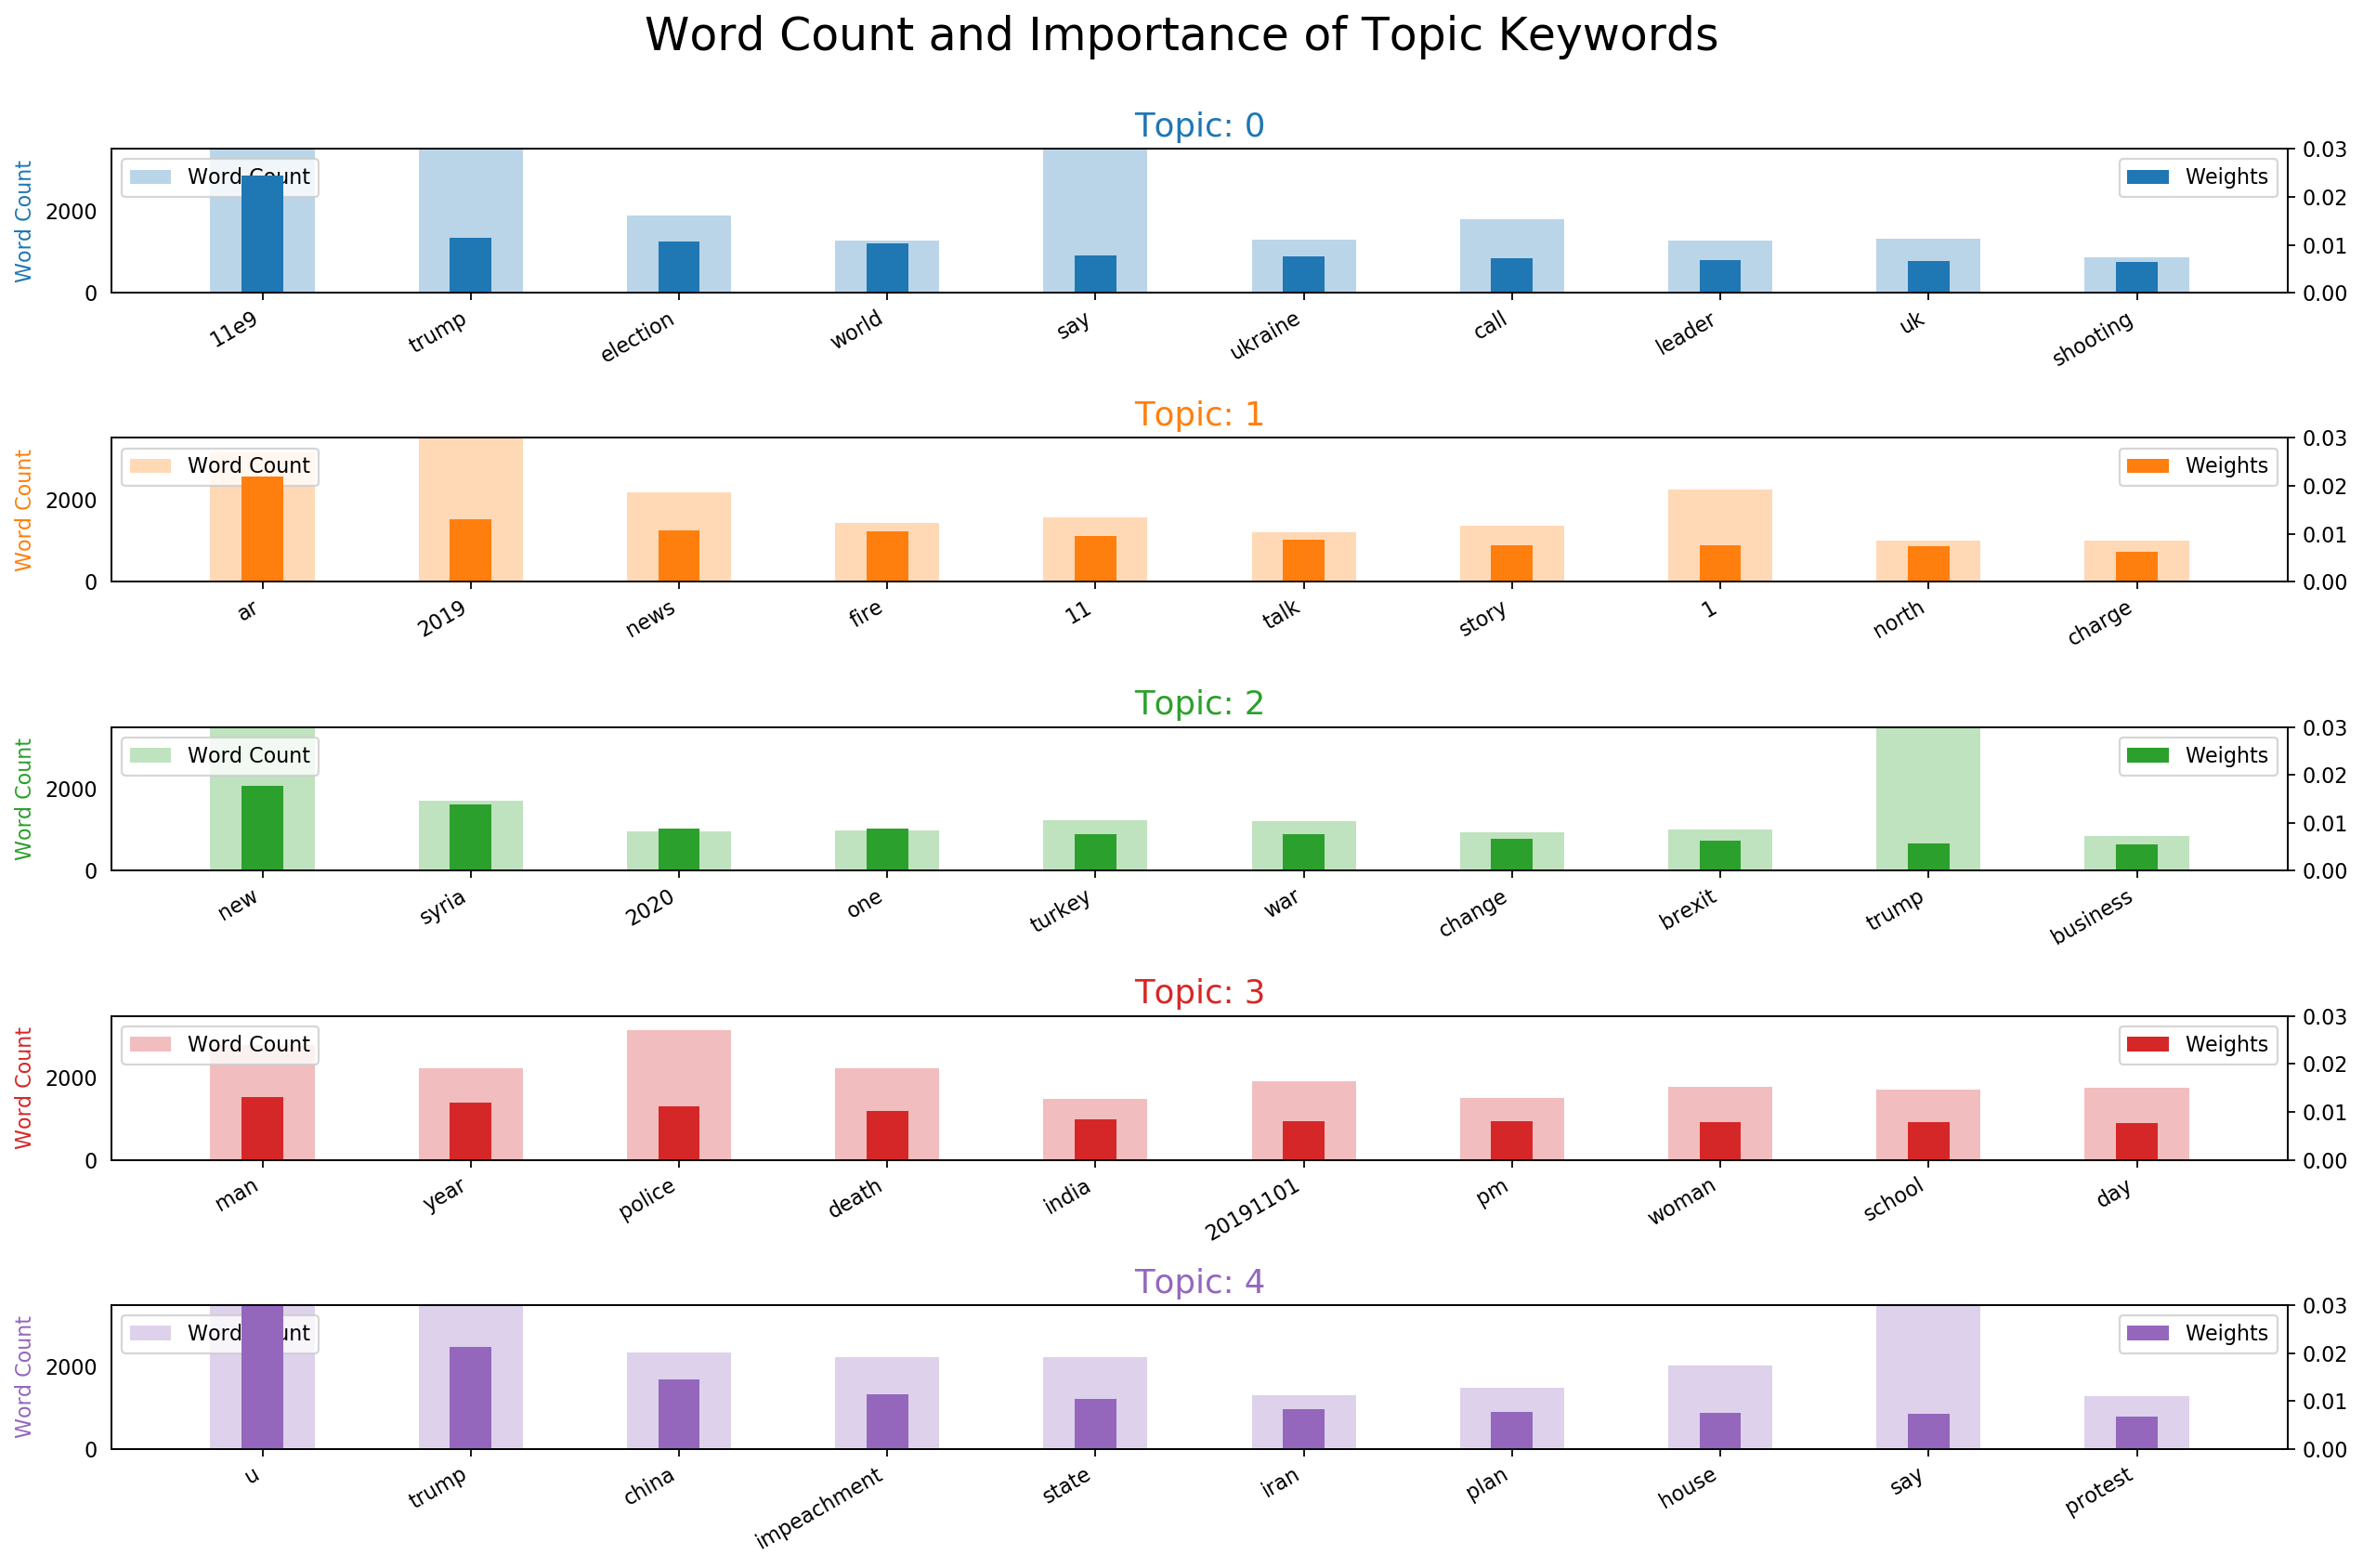

In [29]:
word_cloud(ldamodel5, 3, 2, "word_cloud_single_5_topics", del_x=2, del_y=1)
word_weight(ldamodel5, doc_clean, "word_weights_single_5_topics ", 5, 1)

## USA/CHINA

The USA China Data was taken from the Google Cloud Platform and exported as a csv

In [3]:
us_chn_data = pd.read_csv("fin_test")
us_chn_data = us_chn_data[us_chn_data["SQLDATE"] >= 20200301]
us_chn_data

SQLDATE Actor1Code Actor2Code  EventCode       DATEADDED  \
0     20200301        CHN        USA        256  20200301200000   
1     20200302        CHN        USA        256  20200302000000   
2     20200302        USA        CHN        192  20200302123000   
3     20200302        CHN        USA         15  20200302174500   
4     20200302        USA        CHN         15  20200302174500   
...        ...        ...        ...        ...             ...   
3619  20200418        USA        CHN       1721  20200418033000   
3621  20200416        USA        CHN        163  20200416081500   
3622  20200416        CHN        USA        183  20200416190000   
3623  20200317        USA        CHN        193  20200416153000   
3624  20200415        USA        CHN       1722  20200415201500   

      ActionGeo_Lat  ActionGeo_Long  NumMentions    AvgTone  QuadClass  \
0           35.0000         105.000            3  -2.698023          1   
1           35.0000         105.000            6  -2.781947          1   
2           35.0000         105.000            8  -0.351494          4   
3           35.0000         105.000           10 -18.243243          1   
4           35.0000         105.000            4 -18.243243          1   
...             ...             ...          ...        ...        ...   
3619        39.9289         116.388           10  -4.060914          4   
3621        39.9289         116.388            1  -3.926097          4   
3622        39.9289         116.388            2  -7.387863          4   
3623        39.9289         116.388            4  -3.011204          4   
3624        39.9289         116.388            8  -4.015296          4   

      GoldsteinScale  NumArticles  \
0               -0.3            3   
1               -0.3            6   
2               -9.5            8   
3                0.0           10   
4                0.0            2   
...              ...          ...   
3619            -5.0           10   
3621            -8.0            1   
3622           -10.0            2   
3623           -10.0            4   
3624            -5.0            8   

                                              SOURCEURL  
0     http://www.wboc.com/story/41836455/virus-cases...  
1     https://www.wiscnews.com/news/world/virus-acce...  
2     https://www.thesundaily.my/opinion/birds-of-a-...  
3     https://www.wwnytv.com/2020/03/02/robinson-ple...  
4     https://www.wwnytv.com/2020/03/02/robinson-ple...  
...                                                 ...  
3619  https://www.express.co.uk/news/world/1270605/u...  
3621  https://www.telegraph.co.uk/politics/2020/04/1...  
3622  https://www.taipeitimes.com/News/world/archive...  
3623           https://www.japantimes.co.jp/2020/04/17/  
3624  https://www.breitbart.com/the-media/2020/04/15...  

[3561 rows x 13 columns]

Filter the data

In [4]:
us_doc_complete = [x_split(x).replace("-", " ") for x in us_chn_data["SOURCEURL"] if len(x.split("-")) >1]

### US/China TD-IDF

Perform TF-IDF vectorisation on the USA/CHINA data

In [5]:
vectorizer = TfidfVectorizer(use_idf=True, stop_words=stop_words)
vectors = vectorizer.fit_transform(us_doc_complete)
feature_names = vectorizer.get_feature_names()
dense = vectors.todense()
denselist = dense.tolist()
us_chn_tf = pd.DataFrame(denselist, columns=feature_names)

In [ ]:
# It was tested to see if the results would change drastically if the TF-IDF values 
# were used for only documents where the words existed, but this led to problems with sampling, 
# even when words were only used which existed in at least a percentage of the documents, thus 0 was included

new_data = us_chn_tf.replace(0, np.nan)
new_data = new_data.loc[:, new_data.isnull().mean() <= .99]

In [7]:
means = us_chn_tf.mean(axis=0)
new_df = pd.concat([pd.DataFrame(us_chn_tf.columns.tolist()), pd.DataFrame(means.values)], axis=1)
new_df.columns = ["Word", "TF/IDF"]

In [8]:
data = new_df.sort_values("TF/IDF", ascending=False).head(20)
data.reset_index(inplace=True)
data

index         Word    TF/IDF
0    1831        china  0.034598
1    2033  coronavirus  0.034292
2    2957         html  0.032640
3    5136           us  0.021743
4    5058        trump  0.018129
5    2956          htm  0.016341
6    2070        covid  0.015720
7     212           19  0.014817
8    1838      chinese  0.013019
9    1223           ar  0.011991
10   5198        virus  0.011014
11   3751         news  0.010348
12   5315        world  0.009629
13   3926     pandemic  0.007995
14    254         2020  0.007640
15   4781        story  0.007376
16   1833       chinas  0.007362
17   3750          new  0.007315
18   4007          php  0.006400
19   4491         says  0.005795

Plot the most common words

/cs/home/jk218/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  """Entry point for launching an IPython kernel.


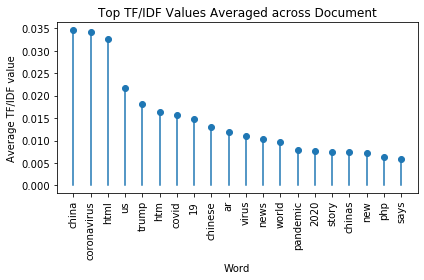

In [32]:
plt.stem(data["Word"], data["TF/IDF"], basefmt=" ")
plt.xticks(rotation=90)
plt.xlabel("Word")
plt.ylabel("Average TF/IDF value")
plt.title("Top TF/IDF Values Averaged across Document")
plt.tight_layout()
plt.savefig("usa_stem_tfidf.png")

Plot the distributions of the TF-IDF values for the most common words excluding 0

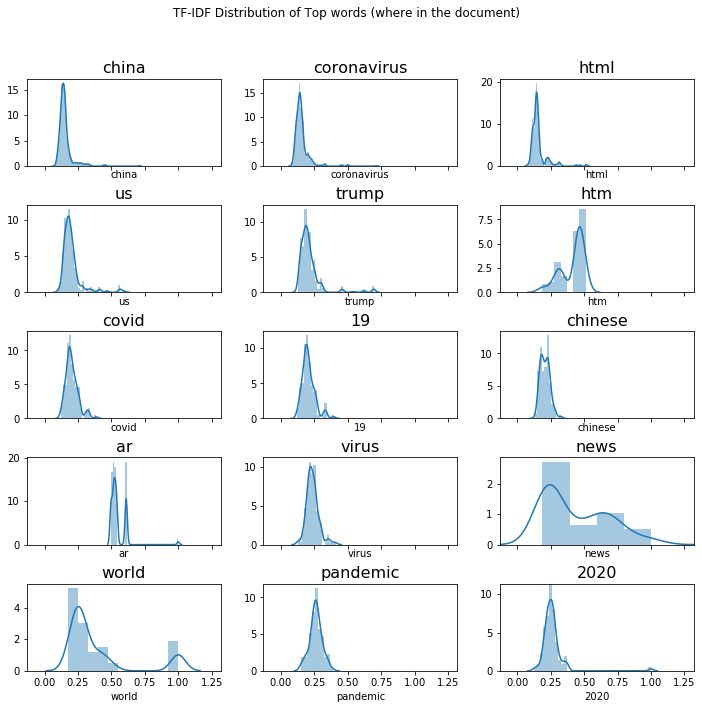

In [54]:
fig, axes = plt.subplots(5, 3, figsize=(10,10),  sharex=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    word = data["Word"][i]
    seaborn.distplot(us_chn_tf[us_chn_tf[word] != 0][word])
    plt.gca().set_title(word, fontdict=dict(size=16))


plt.subplots_adjust(wspace=0, hspace=0)
fig.suptitle("TF-IDF Distribution of Top words (where in the document)\n")
plt.margins(x=0, y=0)
plt.tight_layout()
fig.subplots_adjust(top=0.88)
plt.savefig("usa_tfidf_top_distribution.png")
plt.show()

### USA/China LDA 

Define stop words and punctuation filtering

In [5]:
stop = set(stopwords.words('english'))
exclude = set(string.punctuation) 
lemma = WordNetLemmatizer()

In [6]:
def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

In [7]:
us_doc_complete

['virus cases in italy soar 40 us urges americans not to go',
 'article_7fa2361c 07df 5b9d 9c4b 22e1e9263899.html',
 'birds of a feather flock together NM2068935',
 'robinson pleads guilty forcible touching charge',
 'robinson pleads guilty forcible touching charge',
 'adulting boot camp essential life skills teens canton march 4 june 10 0276047',
 'adulting boot camp essential life skills teens canton march 4 june 10 0276047',
 'u s advisory warns americans not to travel to two regions in italy',
 'id4',
 'super tuesday heres where the democratic presidential candidates stand on tech',
 'article_5ae1dee2 c1bb 53d8 aefe 95e993b0d99e.html',
 'article_b2a2b520 f49b 52eb 846e 6027563e2af2.html',
 'article_b2a2b520 f49b 52eb 846e 6027563e2af2.html',
 'content_75758946.htm',
 'unauthorized history socialism bret baier',
 'virus cases in italy soar 40 us urges americans not to go',
 'virus cases in italy soar 40 us urges americans not to go',
 'ronie berggren wolodarskis fadas om trump ingen

In [8]:
us_doc_clean = [clean(doc).split() for doc in us_doc_complete]   

### LDA Models

Build the document matrix from the cleaned dictionary

In [10]:
us_dictionary = corpora.Dictionary(us_doc_clean)
us_doc_term_matrix = [us_dictionary.doc2bow(doc) for doc in us_doc_clean]

In [13]:
us_doc_term_matrix

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1)],
 [(9, 1), (10, 1), (11, 1), (12, 1), (13, 1)],
 [(14, 1), (15, 1), (16, 1), (17, 1), (18, 1)],
 [(19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1)],
 [(19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1)],
 [(25, 1),
  (26, 1),
  (27, 1),
  (28, 1),
  (29, 1),
  (30, 1),
  (31, 1),
  (32, 1),
  (33, 1),
  (34, 1),
  (35, 1),
  (36, 1),
  (37, 1)],
 [(25, 1),
  (26, 1),
  (27, 1),
  (28, 1),
  (29, 1),
  (30, 1),
  (31, 1),
  (32, 1),
  (33, 1),
  (34, 1),
  (35, 1),
  (36, 1),
  (37, 1)],
 [(1, 1), (4, 1), (6, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1)],
 [(43, 1)],
 [(44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1)],
 [(52, 1), (53, 1), (54, 1), (55, 1), (56, 1)],
 [(57, 1), (58, 1), (59, 1), (60, 1), (61, 1)],
 [(57, 1), (58, 1), (59, 1), (60, 1), (61, 1)],
 [(62, 1)],
 [(63, 1), (64, 1), (65, 1), (66, 1), (67, 1)],
 [(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1),

#### 3 topic model

In [37]:
us_ldamodel = LdaModel(us_doc_term_matrix,num_topics=3, id2word = us_dictionary, passes=50)

In [41]:
us_ldamodel.print_topics(num_topics=3, num_words=3)

[(0, '0.036*"coronavirus" + 0.031*"china" + 0.026*"trump"'),
 (1, '0.049*"china" + 0.030*"u" + 0.023*"coronavirus"'),
 (2, '0.022*"covid" + 0.021*"19" + 0.019*"china"')]

In [42]:
us_ldamodel.get_term_topics("china", minimum_probability=0.000001)

[(0, 0.030535849), (1, 0.048686236), (2, 0.01901468)]

Plots

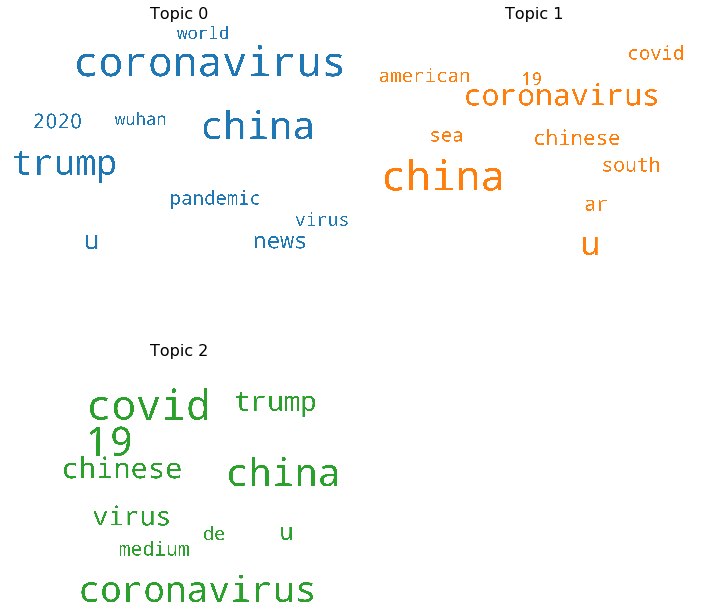

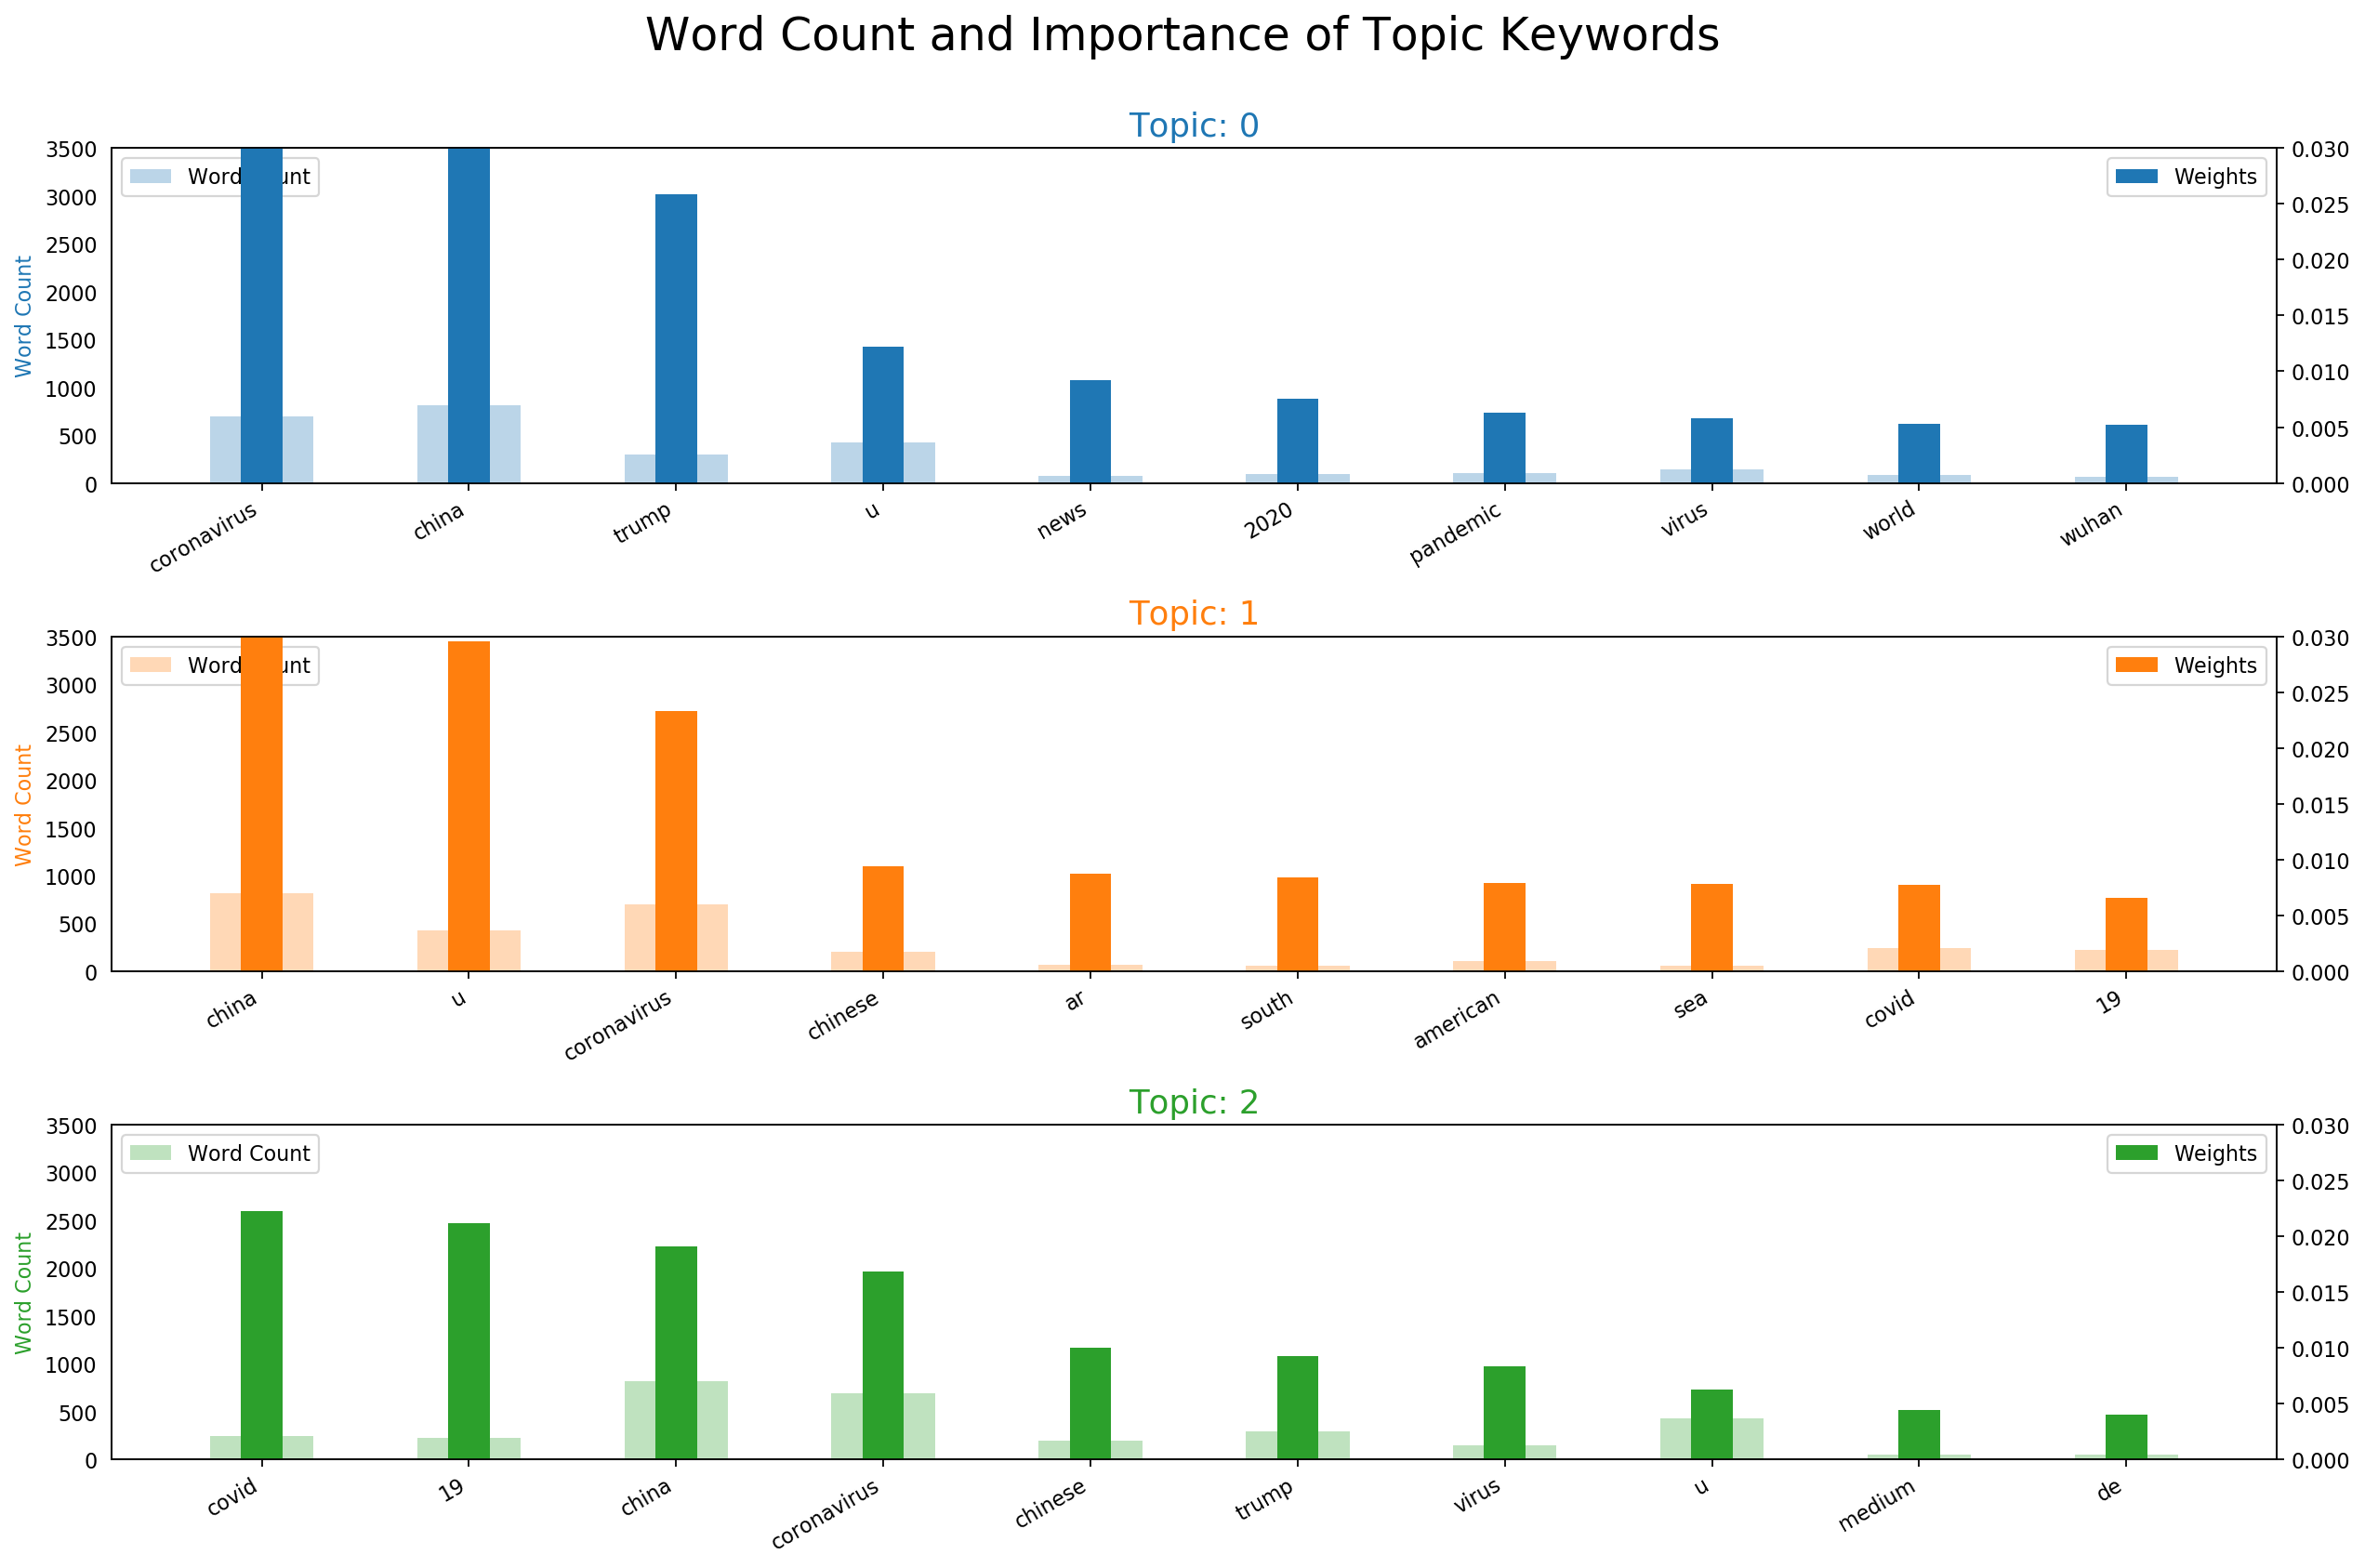

In [49]:
word_cloud(us_ldamodel, 2, 2, "word_cloud_usa_3_topics", del_x=1, del_y=1)
word_weight(us_ldamodel, us_doc_clean, "word_weights_usa_3_topics", 3, 1)

#### 2 topics

In [50]:
us_ldamodel_2 = LdaModel(us_doc_term_matrix, num_topics=2, id2word = us_dictionary, passes=50)
us_ldamodel_2.print_topics(num_topics=2, num_words=3)

[(0, '0.025*"trump" + 0.021*"coronavirus" + 0.015*"china"'),
 (1, '0.048*"china" + 0.030*"u" + 0.029*"coronavirus"')]

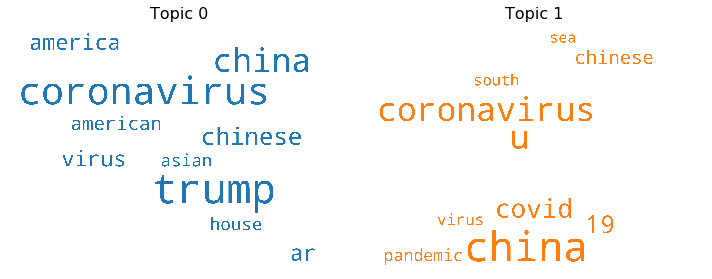

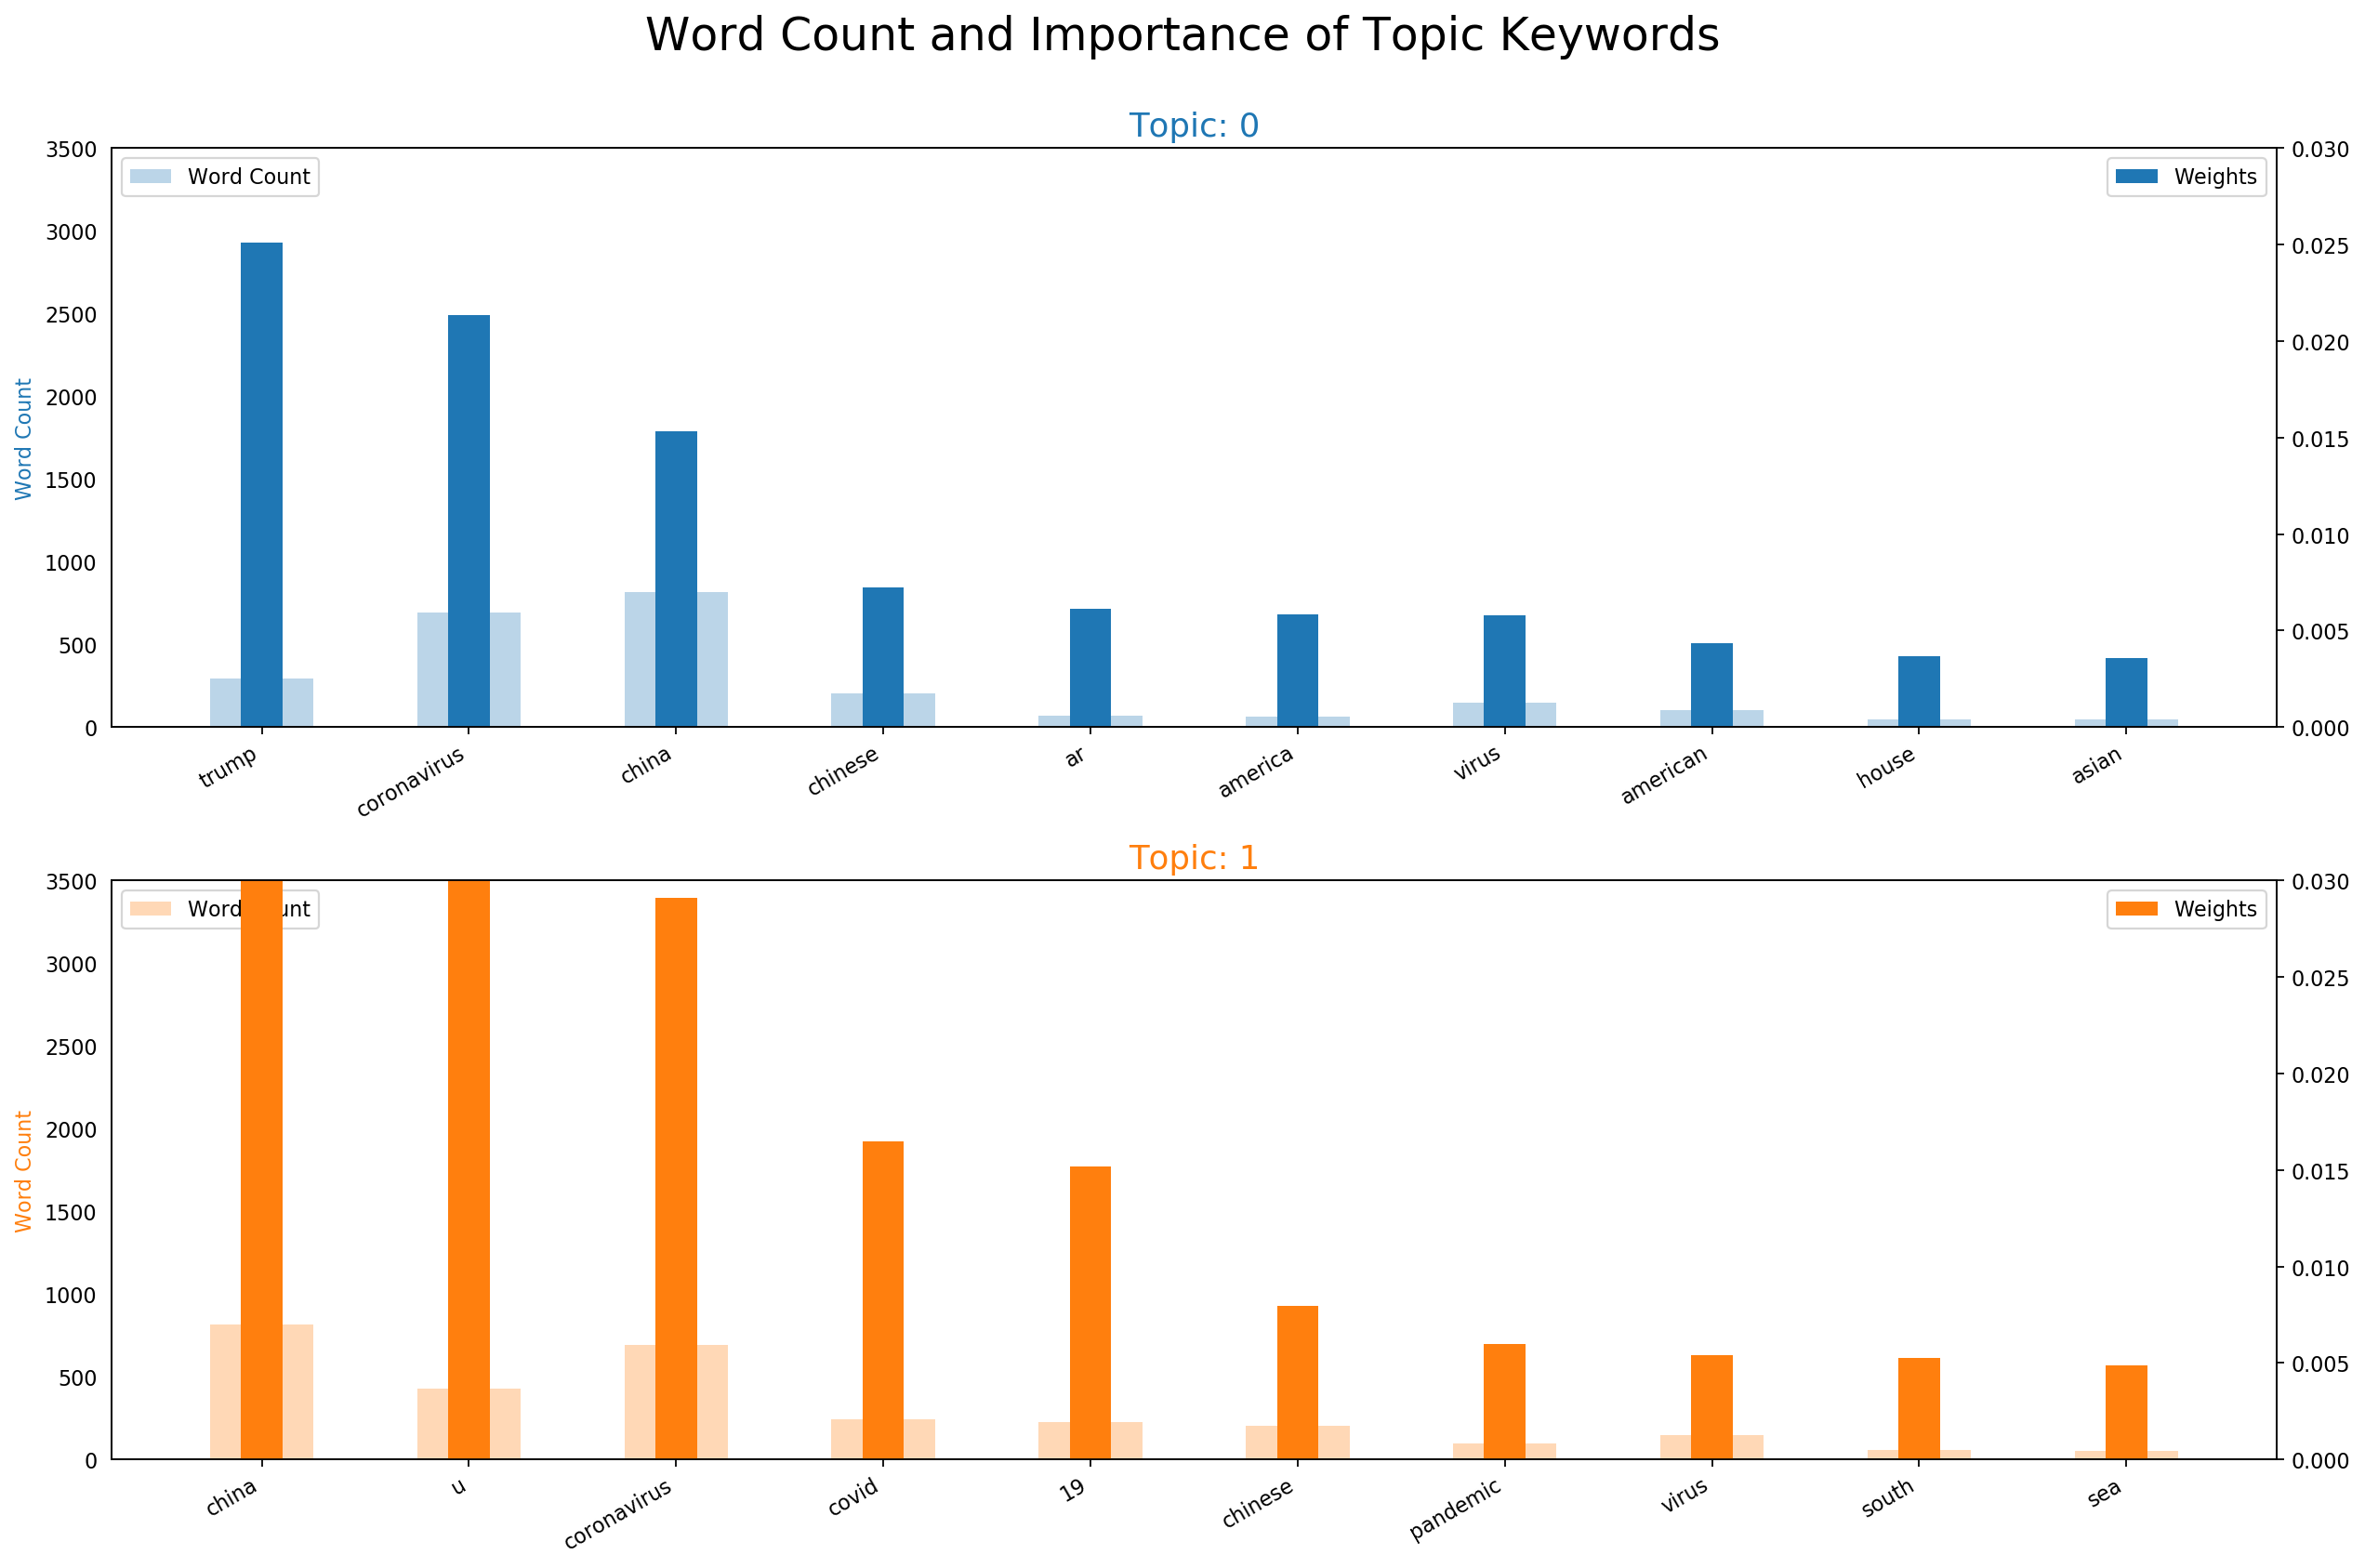

In [51]:
word_cloud(us_ldamodel_2, 1, 2, "word_cloud_usa_2_topics")
word_weight(us_ldamodel_2, us_doc_clean, "word_weights_usa_2_topics", 2, 1)

### 4 topics

In [52]:
us_ldamodel_4 = LdaModel(us_doc_term_matrix, num_topics=4, id2word = us_dictionary, passes=50)
us_ldamodel_4.print_topics(num_topics=4, num_words=3)

[(0, '0.034*"coronavirus" + 0.022*"china" + 0.012*"u"'),
 (1, '0.043*"china" + 0.035*"coronavirus" + 0.020*"trump"'),
 (2, '0.033*"china" + 0.018*"u" + 0.012*"south"'),
 (3, '0.031*"china" + 0.029*"19" + 0.029*"covid"')]

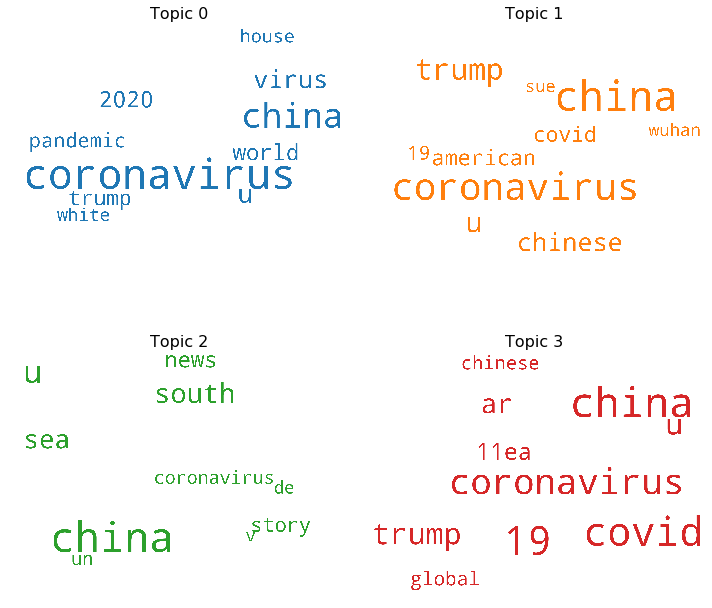

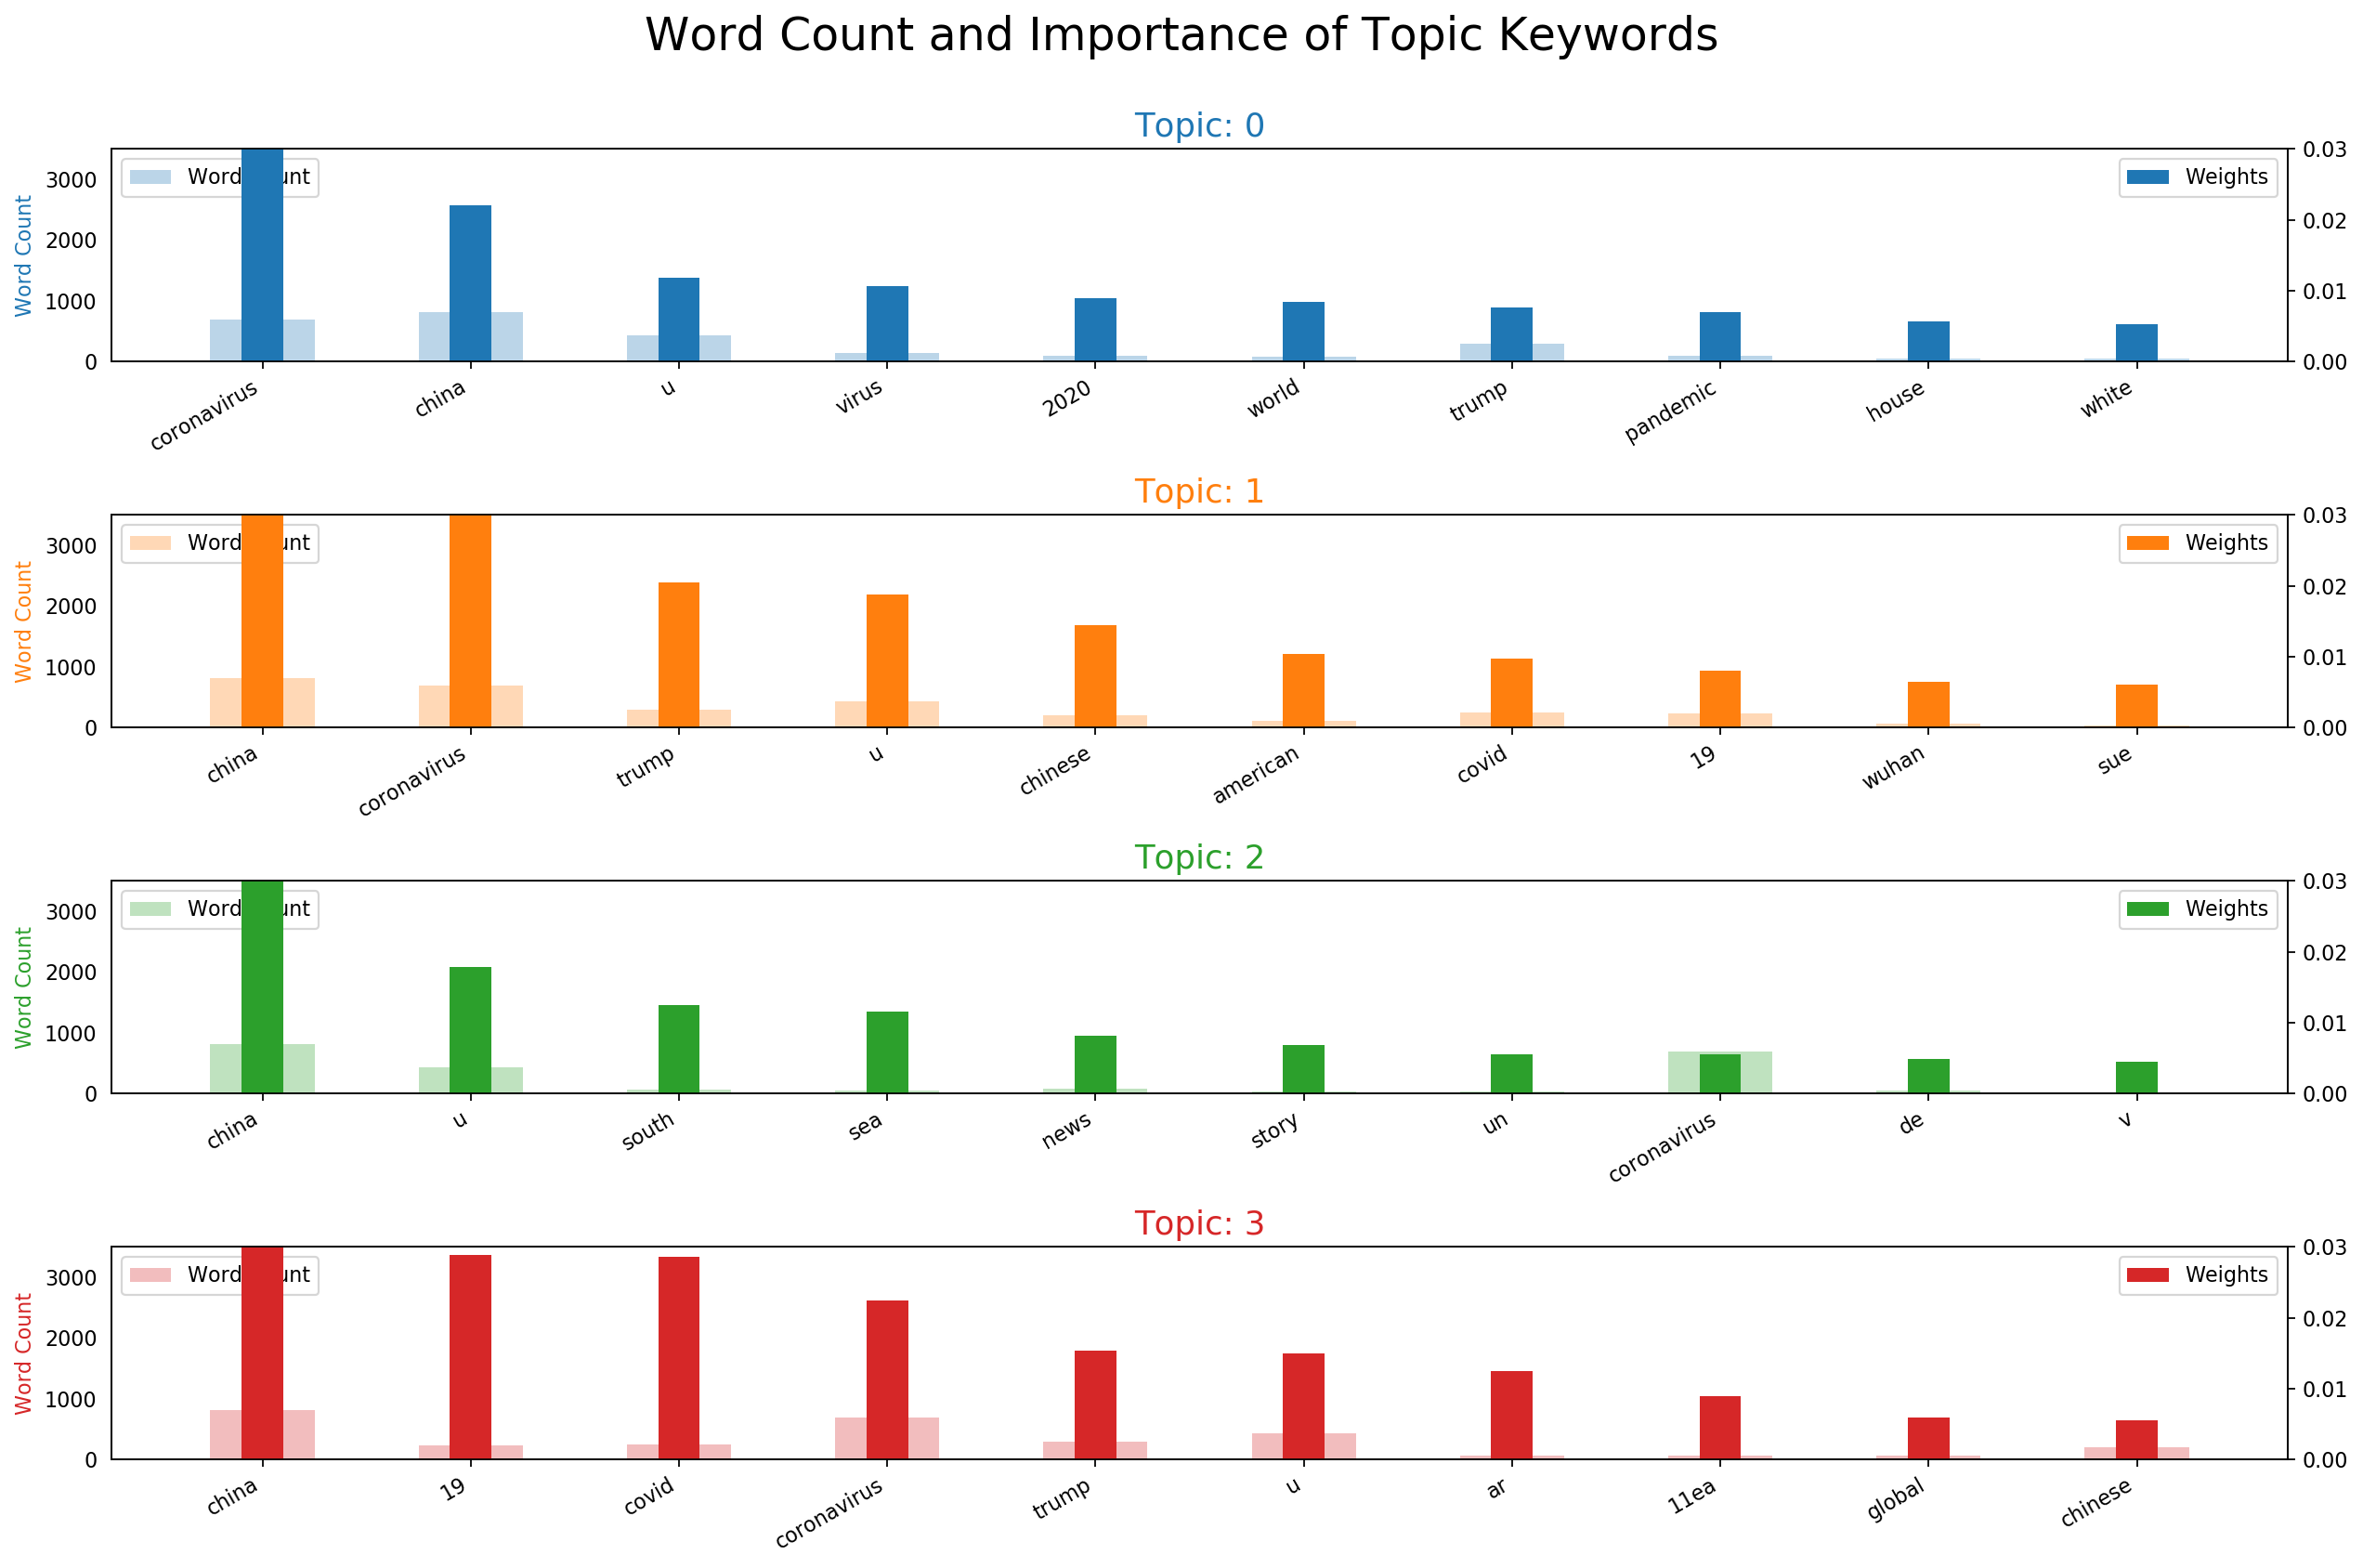

In [53]:
word_cloud(us_ldamodel_4, 2, 2, "word_cloud_usa_4_topics")
word_weight(us_ldamodel_4, us_doc_clean, "word_weights_usa_4_topics", 4, 1)

### Phrase Distance testing

In [38]:
text = ["Brazil", "word", "russia"]
bow = us_dictionary.doc2bow(text)
us_ldamodel.get_document_topics(bow)

[(0, 0.11852425), (1, 0.11132914), (2, 0.7701466)]

In [49]:
words = [
            ["coronavirus hits remote utah"], 
            ["scottish wind power success"], 
            ["trump passes bill"], 
            ["covid"],
            ["aboriginal peoples australia complain"],
            ["nikkei closes 90 points down"]
        ]

In [54]:
for i in words:
    for j in i[0].split(" "):
        print(j)
        print(us_ldamodel.get_term_topics(j, minimum_probability=0.000001))

coronavirus
[(0, 0.02510018), (1, 0.022158574), (2, 0.02865078)]
hits


IndexError: list index out of range

In [55]:
us_ldamodel.get_term_topics("hits", minimum_probability=0.000001)

IndexError: list index out of range

In [57]:
us_ldamodel.get_term_topics("coronavirus", minimum_probability=0.000001)

[(0, 0.02510018), (1, 0.022158574), (2, 0.02865078)]

In [398]:
us_ldamodel[bow]

[(0, 0.7773674), (1, 0.11132562), (2, 0.11130695)]

In [147]:
import numpy as np

Initially when this approach worked on a single word basis, for it to work on an entire headline, it was adapted to average across all of the words for all of the topics

In [19]:
def get_average(text):
    sum_list = []
    for i in text:
        if not sum_list:
            value = [snd for (fst, snd) in us_ldamodel.get_term_topics(i, minimum_probability=0.000001)]
            sum_list = value
        else:
            sum_list = [sum(x) for x in zip(sum_list, value)]
    np.mean(np.array(sum_list)/3)

In [144]:
sum_list

[0.00021230075071798638, 1.7938185465027345e-05, 1.2820160463888897e-05]

## Visualise LDA Model

In [60]:
## Build a word cloud using the lda model 

# word cloud and weights code adapted from 
# https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/

def word_cloud(ldamodel, rows, columns, filename, del_x=None, del_y=None):
    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    cloud = WordCloud(stopwords=stop_words,
                      background_color='white',
                      width=2500,
                      height=1800,
                      max_words=10,
                      colormap='tab10',
                      color_func=lambda *args, **kwargs: cols[i],
                      prefer_horizontal=1.0)

    topics = ldamodel.show_topics(formatted=False)
    fig, axes = plt.subplots(rows, columns, figsize=(10,10), sharex=True, sharey=True)


    for i, ax in enumerate(axes.flatten()):
        if i < len(topics):
            fig.add_subplot(ax)
            topic_words = dict(topics[i][1])
            cloud.generate_from_frequencies(topic_words, max_font_size=300)
            plt.gca().imshow(cloud)
            plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
            plt.gca().axis('off')
    
    if del_x is not None and del_y is not None:
        fig.delaxes(axes[del_x,del_y])
        
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.axis('off')
    plt.margins(x=0, y=0)
    plt.tight_layout()
    plt.savefig(filename + ".png")

In [61]:
## Plot word count and weights
def word_weight(ldamodel, documents, filename, x, y):
    topics = ldamodel.show_topics(formatted=False)
    data_flat = [w for w_list in documents for w in w_list]
    counter = Counter(data_flat)

    out = []
    for i, topic in topics:
        for word, weight in topic:
            out.append([word, i , weight, counter[word]])

    df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

    # Plot Word Count and Weights of Topic Keywords
    fig, axes = plt.subplots(x, y, figsize=(16,10), sharey=True, dpi=160)
    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
    for i, ax in enumerate(axes.flatten()):
        ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
        ax_twin = ax.twinx()
        ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
        ax.set_ylabel('Word Count', color=cols[i])
        ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
        ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
        ax.tick_params(axis='y', left=False)
        ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
        ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

    fig.tight_layout(w_pad=2)    
    fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
    plt.savefig(filename + ".png")
    plt.show()

## K Means

ref http://jonathansoma.com/lede/algorithms-2017/classes/clustering/k-means-clustering-with-scikit-learn/

### Pre-filtering

In [9]:
def textblob_tokenizer(str_input):
    blob = TextBlob(str_input.lower())
    tokens = blob.words
    words = [token.stem() for token in tokens]
    return words


In [10]:
texts =  [' '.join(i) for i in us_doc_clean]
texts = [i for i in texts if len(i.split(" ")) > 1]

In [11]:
texts

['virus case italy soar 40 u urge american go',
 'article7fa2361c 07df 5b9d 9c4b 22e1e9263899html',
 'bird feather flock together nm2068935',
 'robinson pleads guilty forcible touching charge',
 'robinson pleads guilty forcible touching charge',
 'adulting boot camp essential life skill teen canton march 4 june 10 0276047',
 'adulting boot camp essential life skill teen canton march 4 june 10 0276047',
 'u advisory warns american travel two region italy',
 'super tuesday here democratic presidential candidate stand tech',
 'article5ae1dee2 c1bb 53d8 aefe 95e993b0d99ehtml',
 'articleb2a2b520 f49b 52eb 846e 6027563e2af2html',
 'articleb2a2b520 f49b 52eb 846e 6027563e2af2html',
 'unauthorized history socialism bret baier',
 'virus case italy soar 40 u urge american go',
 'virus case italy soar 40 u urge american go',
 'ronie berggren wolodarskis fadas om trump ingen overraskning',
 'ronie berggren wolodarskis fadas om trump ingen overraskning',
 'article7fa2361c 07df 5b9d 9c4b 22e1e926389

In [12]:
# Perform TF-IDF vectorisation on the data, there still remain minor parsing errors 

In [13]:
vec = TfidfVectorizer(tokenizer=textblob_tokenizer,
                      stop_words=stop_words,
                      use_idf=True)
matrix = vec.fit_transform(texts)

/cs/home/jk218/.local/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'ha', 'hi', 'might', 'must', "n't", 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'wa', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


## Calculate a solution of the inverse for the texts

The matrix is singular so lstsq is used to approximate the solution

In [47]:
cov_mat = np.cov(matrix.todense().transpose())
inv = np.linalg.lstsq(cov_mat, np.identity(cov_mat.shape[0]))

/cs/home/jk218/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


### k = 2

In [14]:
number_of_clusters = 2
km_2 = KMeans(n_clusters=number_of_clusters, random_state=0)
distances_to_centres = km_2.fit_transform(matrix)

In [15]:
print("Top terms per cluster:")
order_centroids = km_2.cluster_centers_.argsort()[:, ::-1]
terms = vec.get_feature_names()
for i in range(number_of_clusters):
    top_ten_words = [terms[ind] for ind in order_centroids[i, :3]]
    print("Cluster {}: {}".format(i, ' '.join(top_ten_words)))

Top terms per cluster:
Cluster 0: china coronaviru u
Cluster 1: covid 19 china


In [34]:
k=2
km = km_2
labels = km.predict(matrix)
X = matrix.todense()
cmap = ListedColormap(seaborn.color_palette("hls", k))

Plot the mahalanobis and euclidean distances and the word clouds

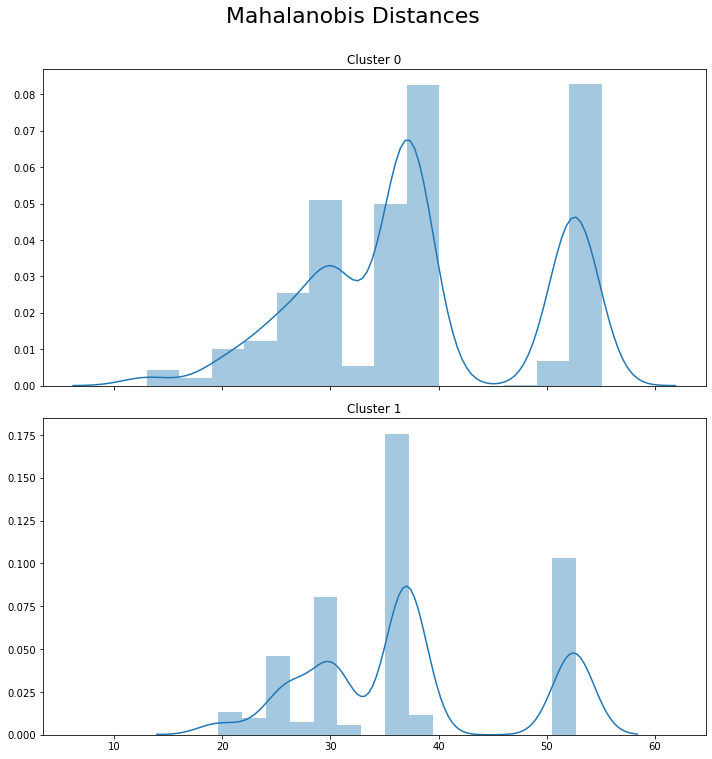

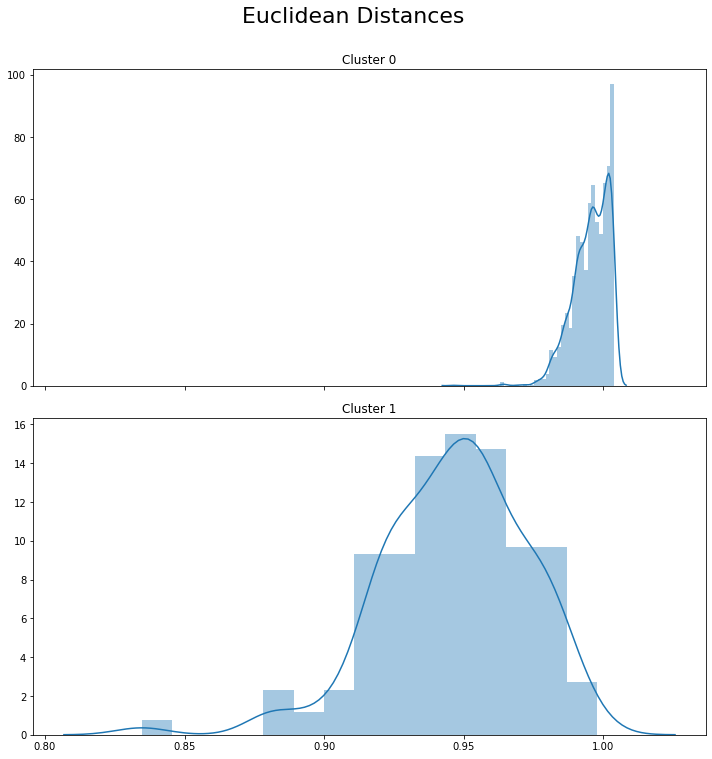

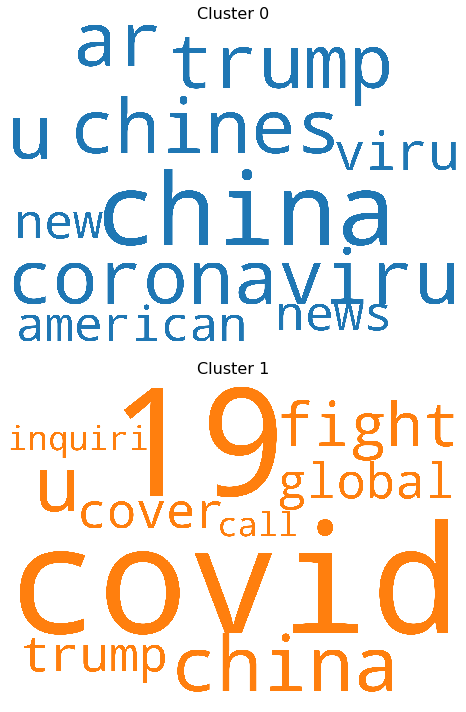

In [24]:
plot_distance(km_2)
plot_word_cloud_kmeans(km_2, 2, 2, 1)

plot the T-SNE and the PCA plots

In [38]:
def pca_tsne(km, k, matrix):
    labels = km.predict(matrix)
    X = matrix.todense()
    cmap = cmap = ListedColormap(seaborn.color_palette("hls", k))
    labels_color_map = {
        0: '#20b2aa', 1: '#ff7373', 2: '#ffe4e1', 3: '#005073', 4: '#4d0404'
    }
    
    
    # pca 2 Dimensional
    pca_num_components = 2

    pca = PCA(n_components=pca_num_components)
    reduced_values = pca.fit_transform(X)
    eigenvalues = pca.explained_variance_     
    
    fig= plt.figure(figsize=(7,5))
    seaborn.scatterplot(
    x=reduced_values[:, 0], y=reduced_values[:, 1],
    hue=labels,
    palette=seaborn.color_palette("hls", k),
    legend="full",
    alpha=0.4
    )
    plt.xlabel("PCA Dimension 1\n Explained Variance: " + str(round(eigenvalues[0], 4)))
    plt.ylabel("PCA Dimension 2\n Explained Variance: " + str(round(eigenvalues[1], 4)))
    plt.title("2D PCA Plot for k=" + str(k))
    plt.savefig("kmeans_2d_pca_k=" + str(k) + ".png")
    plt.tight_layout()
    plt.close()

    # T-sne 2 dimensional
    tsne_num_components = 2
    embeddings = TSNE(n_components=tsne_num_components)
    Y = embeddings.fit_transform(X)
    fig = plt.figure(figsize=(7,5))
    seaborn.scatterplot(
        x=Y[:, 0], y=Y[:, 1],
        hue=labels,
        palette=seaborn.color_palette("hls", k),
        legend="full",
        alpha=0.4
    )
    plt.title("2D T-SNE plot for k=" + str(k))
    plt.tight_layout()
    plt.savefig("kmeans_2d_tsne_k=" + str(k) + ".png")
    
    # pca 3 Dimensional
    
    pca_num_components = 3
    pca = PCA(n_components=pca_num_components)
    reduced_values = pca.fit_transform(X)
    eigenvalues = pca.explained_variance_

    fig = plt.figure(figsize=(7,6))
    axes = Axes3D(fig)
    axes.scatter(reduced_values[:,0], reduced_values[:,1], reduced_values[:,2], cmap=cmap, c=labels)

    pal = seaborn.color_palette("hls", k)  
    scatter = []
    cluster_labels = []
    for i in range(0,k):
        scatter.append(matplotlib.lines.Line2D([0],[0], linestyle="none", c=pal[i], marker = 'o'))
        cluster_labels.append("Cluster " + str(i))
    
    axes.set_xlabel("PCA Dimension 1\n Explained Variance: " + str(round(eigenvalues[0], 4)))
    axes.set_ylabel("PCA Dimension 2\n Explained Variance: " + str(round(eigenvalues[1], 4)))
    axes.set_zlabel("PCA Dimension 3\n Explained Variance: " + str(round(eigenvalues[2], 4)))
    plt.title("3D PCA Plot for k=" + str(k))
    axes.legend(scatter, cluster_labels, numpoints = 1)
    plt.tight_layout()
    plt.savefig("kmeans_3d_pca_k=" + str(k) + ".png")

    # T-SNE 3 Dimensional
    
    tsne_num_components = 3
    embeddings = TSNE(n_components=tsne_num_components)
    Y = embeddings.fit_transform(X)
    pal = seaborn.color_palette("hls", k)
    
    fig = plt.figure(figsize=(7,6))
    axes = Axes3D(fig)
    axes.scatter(Y[:,0], Y[:,1], Y[:,2], c=labels, cmap=cmap)

    scatter = []
    cluster_labels = []
    for i in range(0,k):
        scatter.append(matplotlib.lines.Line2D([0],[0], linestyle="none", c=pal[i], marker = 'o'))
        cluster_labels.append("Cluster " + str(i))
    
    axes.legend(scatter, cluster_labels, numpoints = 1)
    plt.title("3D T-SNE plot for k=" + str(k))
    plt.tight_layout()
    plt.savefig("kmeans_3d_tsne_k=" + str(k) + ".png")

/cs/home/jk218/.local/lib/python3.7/site-packages/ipykernel_launcher.py:71: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/cs/home/jk218/.local/lib/python3.7/site-packages/ipykernel_launcher.py:93: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


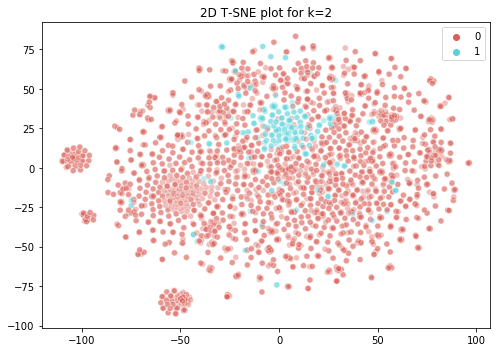

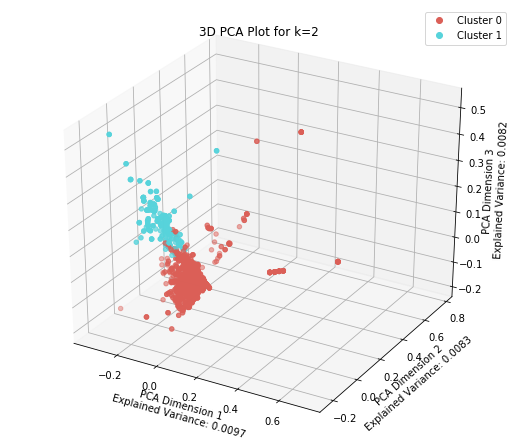

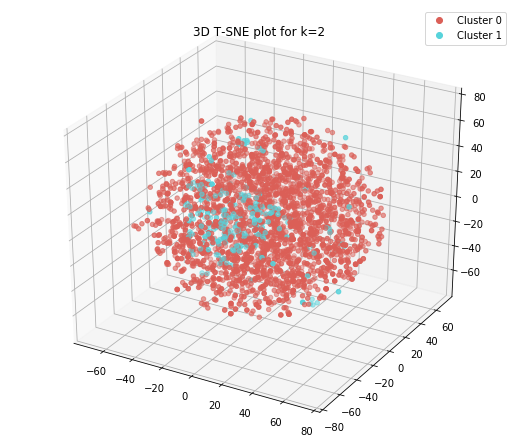

In [39]:
pca_tsne(km_2, 2, matrix)

Define the words to be tested

In [17]:
words = [
            ["coronavirus hits remote utah"], 
            ["scottish wind power success"], 
            ["trump passes bill"], 
            ["covid"],
            ["aboriginal peoples australia complain"],
            ["nikkei closes 90 points down"]
        ]

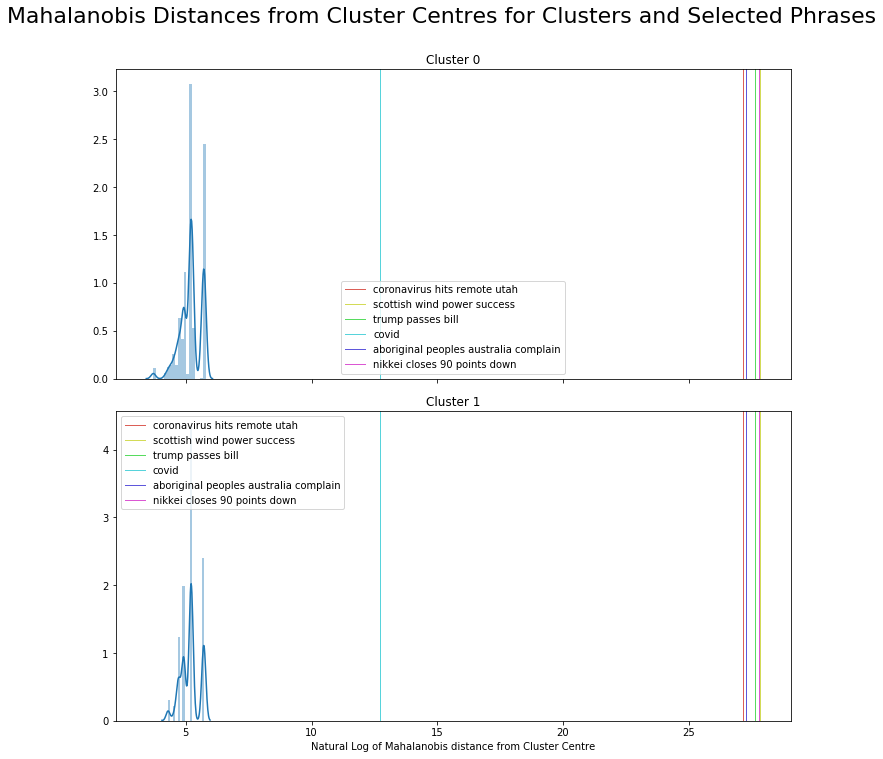

In [23]:
plot_words_on_dist(km_2, words)

### k = 3 

In [40]:
number_of_clusters = 3
km_3 = KMeans(n_clusters=number_of_clusters, random_state=0)
distances_to_centres = km_3.fit_transform(matrix)

print("Top terms per cluster:")
order_centroids = km_3.cluster_centers_.argsort()[:, ::-1]
terms = vec.get_feature_names()
for i in range(number_of_clusters):
    top_ten_words = [terms[ind] for ind in order_centroids[i, :3]]
    print("Cluster {}: {}".format(i, ' '.join(top_ten_words)))

Top terms per cluster:
Cluster 0: trump coronaviru donald
Cluster 1: covid 19 china
Cluster 2: china coronaviru u


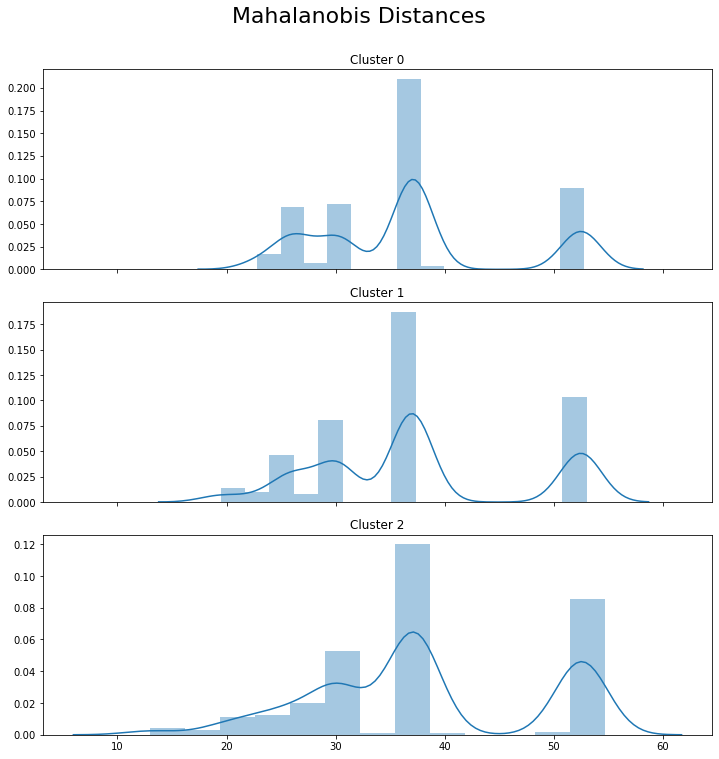

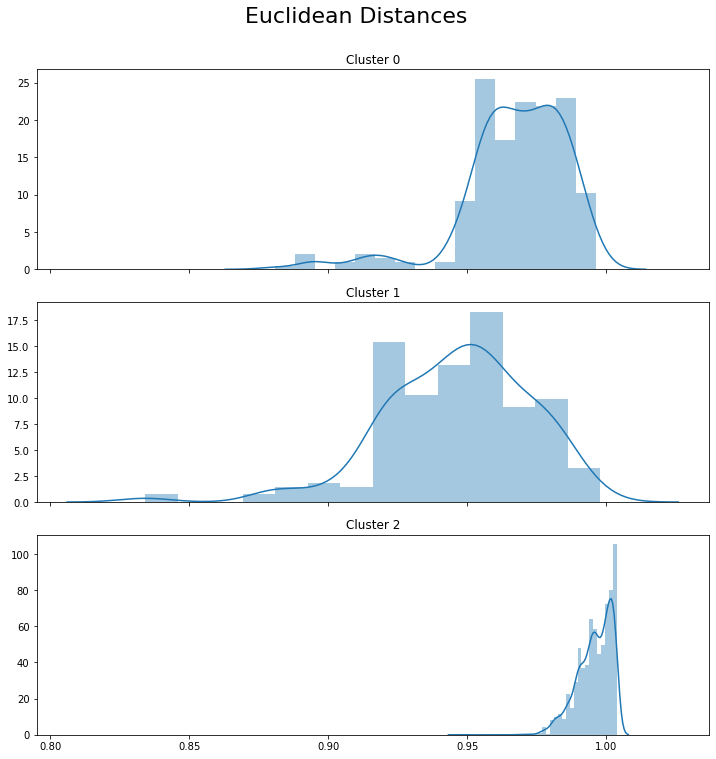

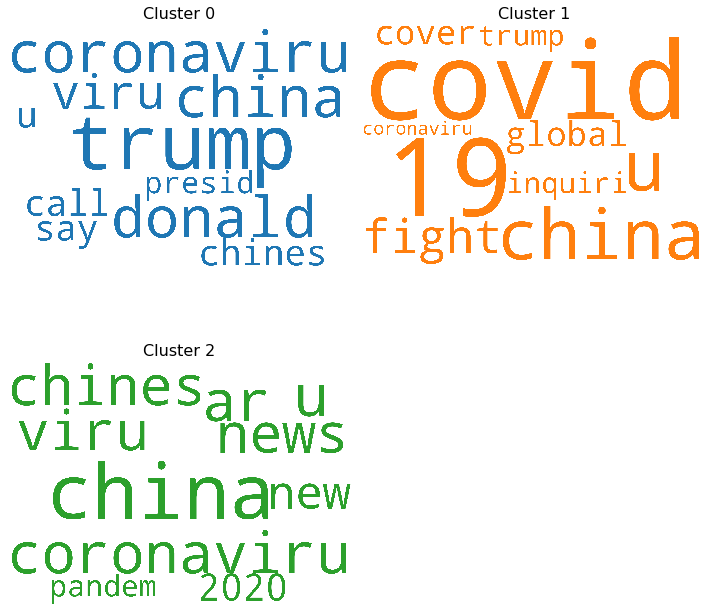

In [27]:
plot_distance(km_3)
plot_word_cloud_kmeans(km_3, 3, 2, 2, 1, 1)

/cs/home/jk218/.local/lib/python3.7/site-packages/ipykernel_launcher.py:71: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/cs/home/jk218/.local/lib/python3.7/site-packages/ipykernel_launcher.py:93: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


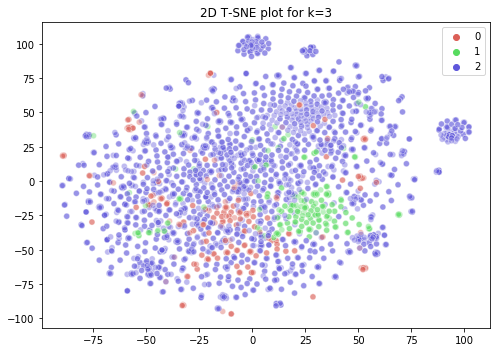

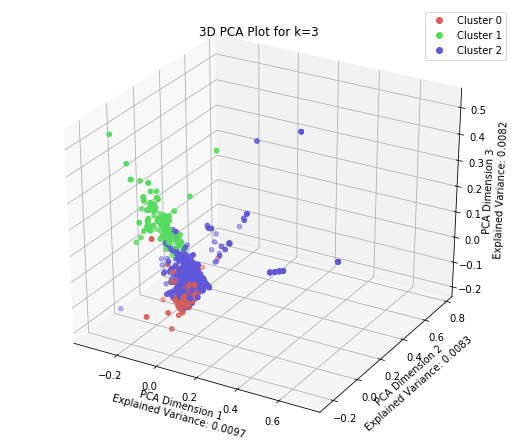

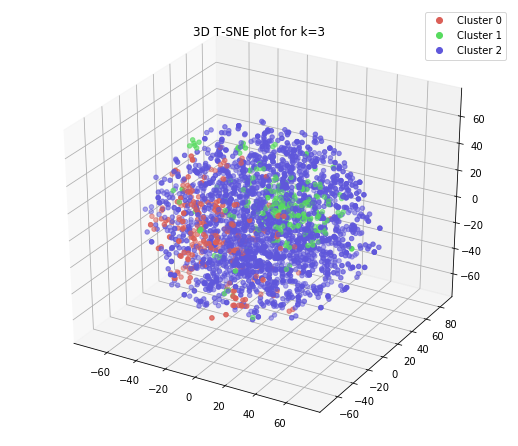

In [41]:
pca_tsne(km_3, 3, matrix)

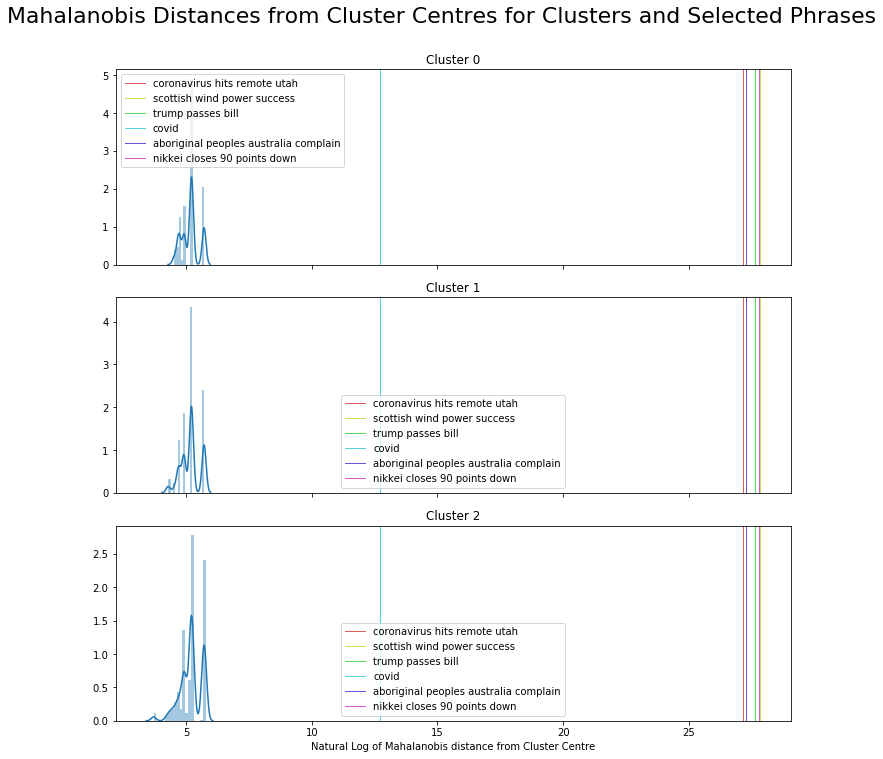

In [25]:
plot_words_on_dist(km_3, words)

### k=4 

In [42]:
number_of_clusters = 4
km_4 = KMeans(n_clusters=number_of_clusters, random_state=0)
distances_to_centres = km_4.fit_transform(matrix)

print("Top terms per cluster:")
order_centroids = km_4.cluster_centers_.argsort()[:, ::-1]
terms = vec.get_feature_names()
for i in range(number_of_clusters):
    top_ten_words = [terms[ind] for ind in order_centroids[i, :3]]
    print("Cluster {}: {}".format(i, ' '.join(top_ten_words)))

Top terms per cluster:
Cluster 0: trump coronaviru donald
Cluster 1: covid 19 china
Cluster 2: china u ar
Cluster 3: coronaviru china u


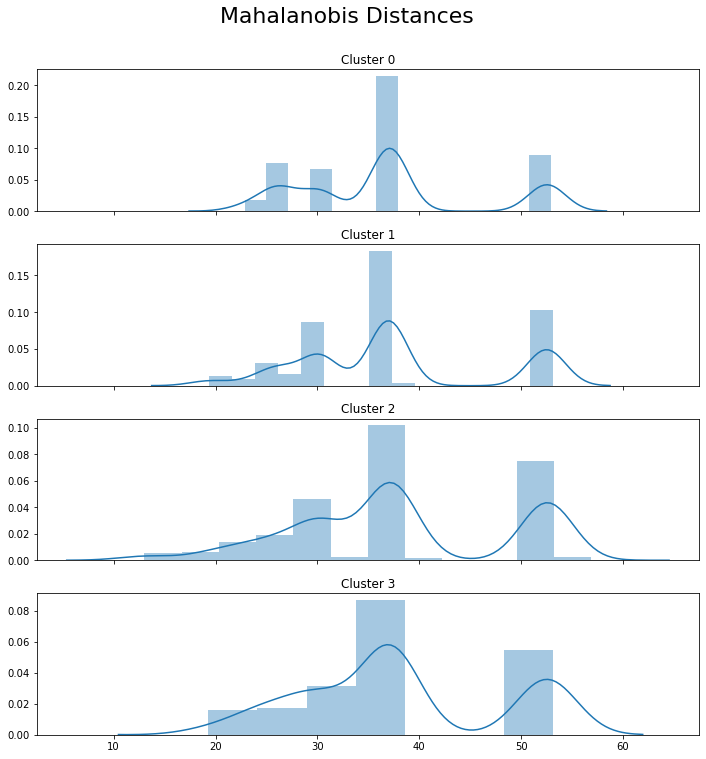

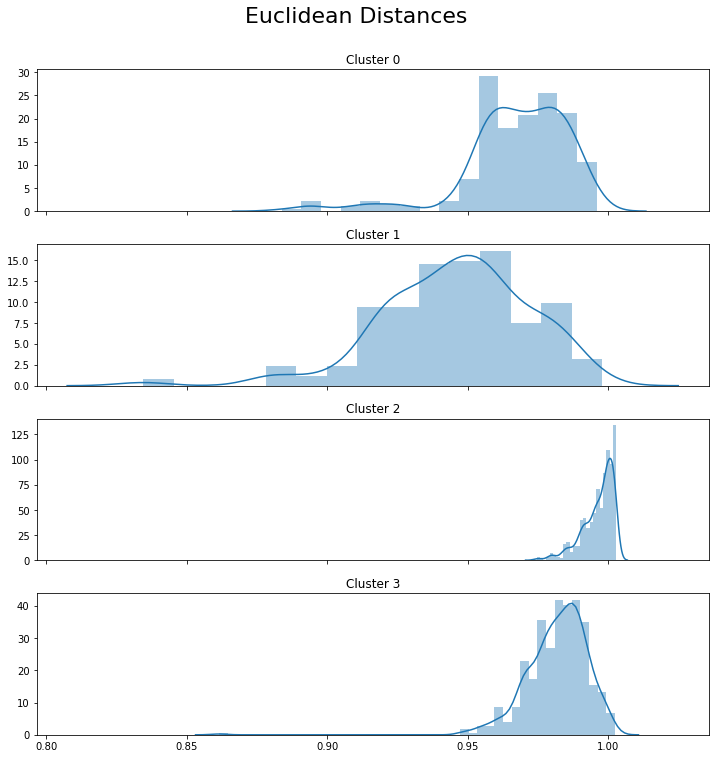

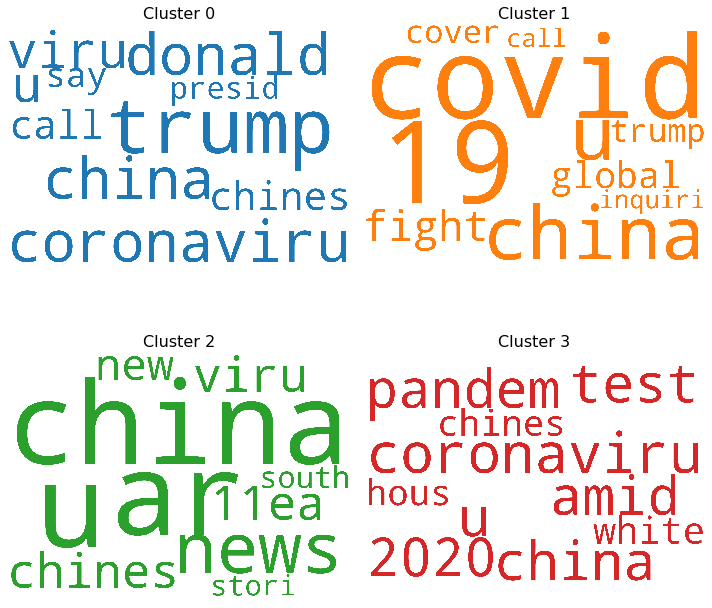

In [30]:
plot_distance(km_4)
plot_word_cloud_kmeans(km_4, 4, 2, 2)

/cs/home/jk218/.local/lib/python3.7/site-packages/ipykernel_launcher.py:71: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/cs/home/jk218/.local/lib/python3.7/site-packages/ipykernel_launcher.py:93: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


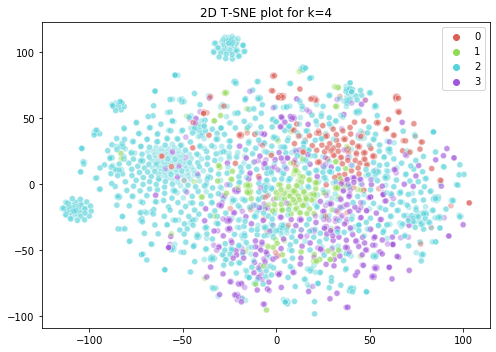

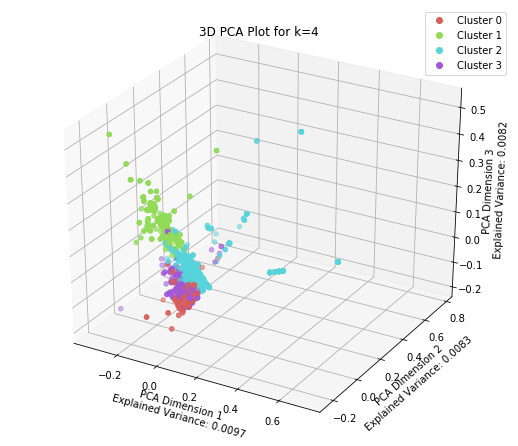

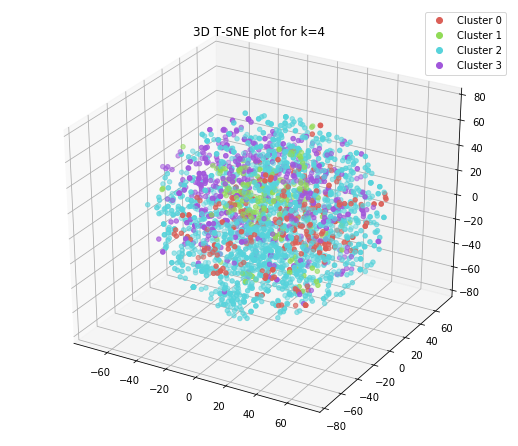

In [43]:
pca_tsne(km_4, 4, matrix)

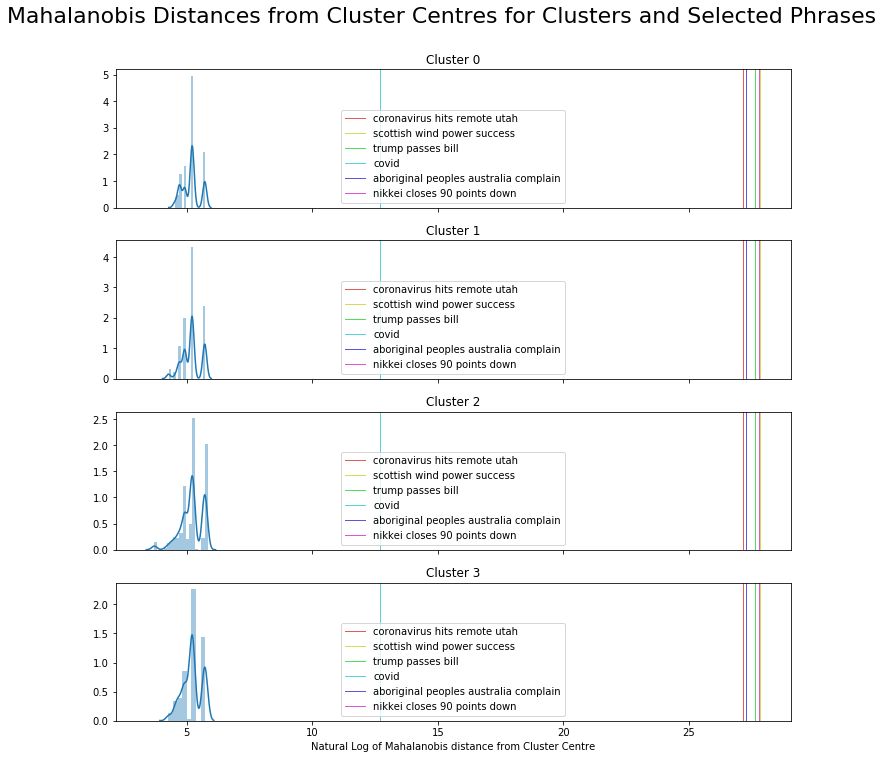

In [27]:
plot_words_on_dist(km_4, words)

## Predictions and transformation examples

In [31]:
km.predict(vec.transform(["Xi"]))

array([0], dtype=int32)

In [32]:
km.transform(vec.transform(["covid 19"]))

array([[1.00307482, 0.72013088]])

In [34]:
km.transform(vec.transform(["namaste"]))

array([[0.08297415, 0.32757172]])

In [33]:
print(km.cluster_centers_.shape)

(2, 4870)


In [34]:
vec.transform(["china covid"]).todense().shape

(1, 4870)

## Inverse individual distance examples

In [30]:
inv[0]

array([[-2.31064988e+16,  7.65387141e+15,  2.74502350e+16, ...,
         4.07915934e+14,  1.34183088e+15,  2.16381012e+14],
       [ 7.51865095e+15,  6.14136969e+15, -1.29803817e+16, ...,
        -1.24192404e+14,  1.71246506e+14, -9.09889641e+14],
       [ 2.32787576e+16, -2.92707974e+16, -2.37155900e+14, ...,
         1.63938794e+15,  4.85188551e+14,  7.09063997e+14],
       ...,
       [-1.65933246e+15,  5.53138161e+14,  5.47754515e+15, ...,
         1.11038892e+16,  2.72726581e+14, -8.02763141e+14],
       [ 5.23615962e+14, -3.57233637e+14,  1.42345102e+14, ...,
         1.92403840e+14, -1.77943503e+13,  1.15308324e+14],
       [ 1.25908637e+15, -1.01831902e+14, -9.12696026e+13, ...,
        -4.60465734e+14,  7.85069244e+13, -6.59225714e+14]])

In [36]:
cov_mat.shape

(4582, 4582)

In [37]:
metric = DistanceMetric.get_metric('mahalanobis', VI=inv[0])

In [27]:
other_dist = []
trans_vec = np.asarray(vec.transform(["covid"]).todense()).reshape(-1)
for i in range(0,km.cluster_centers_.shape[0]):
    other_dist.append((i, metric.pairwise([km.cluster_centers_[i,:], trans_vec])))
    other_dist.append((i, distance.mahalanobis(km.cluster_centers_[i,:], trans_vec, inv[0])))

other_dist

NameError: name 'km' is not defined

### Visualise Mahalanobis distance

In [22]:
def calculate_distances(km):
    mydict = {i: np.where(km.labels_ == i)[0] for i in range(km.n_clusters)}
    dist = {}
    dist["mh"] = {}
    dist["eu"] = {}
    for i in mydict.keys():
        dist["mh"][i] = []
        dist["eu"][i] = []
        for j in mydict[i]:
            dist["mh"][i].append(distance.mahalanobis(km.cluster_centers_[i,:], matrix[j].todense(), inv[0]))
            dist["eu"][i].append( euclidean_distances([km.cluster_centers_[i,:]], matrix[j].todense())[0][0])
            
    return mydict, dist

In [99]:
def plot_distance(km):
    mydict, dist = calculate_distances(km)
    
    
    fig, axes = plt.subplots(len(mydict.keys()), 1, figsize=(10,10), sharex=True)
    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
    for i, ax in enumerate(axes.flatten()):
        fig.add_subplot(ax)
        seaborn.distplot(dist["mh"][i]).set_title("Cluster " + str(i))


    fig.tight_layout(w_pad=2)    
    fig.suptitle('Mahalanobis Distances ', fontsize=22, y=1.05)    
    plt.savefig("kmeans_mahalanobis_distance_k=" + str(len(mydict.keys())) +  ".png")
    
    fig, axes = plt.subplots(len(mydict.keys()), 1, figsize=(10,10),sharex=True)
    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
    for i, ax in enumerate(axes.flatten()):
        fig.add_subplot(ax)
        seaborn.distplot(dist["eu"][i]).set_title("Cluster " + str(i))


    fig.tight_layout(w_pad=2)    
    fig.suptitle('Euclidean Distances ', fontsize=22, y=1.05)    
    plt.savefig("kmeans_euclidean_distance_k=" + str(len(mydict.keys())) +  ".png")


In [19]:
def other_k(km, phrases, func=None):
    
    other_dist = []
    trans_vec =[]
    
    for i in phrases: 
        trans_vec.append(np.asarray(vec.transform(i).todense()).reshape(-1))
    
    for j in trans_vec:
        temp = []
        eu = [] 
        for i in range(0,km.cluster_centers_.shape[0]):
            if func != None:
                temp.append((i, func(distance.mahalanobis(km.cluster_centers_[i,:], j, inv[0]))))
            else:
                temp.append((i, distance.mahalanobis(km.cluster_centers_[i,:], j, inv[0])))
        other_dist.append(temp)
        
    return other_dist

In [126]:
word_dist = other_k(km_2, words, func=np.log2)
print(word_dist)

[[(0, 27.160401076636383), (1, 27.160401076636386)], [(0, 27.843921331016855), (1, 27.843921331016855)], [(0, 27.63176285661897), (1, 27.63176285661897)], [(0, 12.701735376209717), (1, 12.701733692070123)], [(0, 27.26416060521605), (1, 27.264160605216052)], [(0, 27.796505573680385), (1, 27.79650557368039)]]


In [131]:
mydict, dist = calculate_distances(km_2)

In [132]:
for i in dist["mh"]:
    dist["mh"][i] = [np.log2(j) for j in dist["mh"][i]]
mh_dist = dist["mh"]

In [134]:
mh_dist

{0: [4.918849123052064,
  4.899649571313465,
  5.216737641915909,
  5.189653319552202,
  5.189653319552202,
  5.209021195334205,
  5.209021195334205,
  4.885445328448992,
  5.2232832762648265,
  5.71642383271189,
  5.24352121959882,
  5.24352121959882,
  5.248293652627836,
  4.918849123052064,
  4.918849123052064,
  5.20755804536947,
  5.20755804536947,
  4.899649571313465,
  4.899649571313465,
  4.885445328448992,
  4.885445328448992,
  5.710251692779167,
  5.72529752012972,
  5.713847506859293,
  5.7146448933636,
  5.706287356929061,
  4.84691455416976,
  4.84691455416976,
  5.709521537242839,
  4.895054942248458,
  5.732377742936299,
  5.248293652627836,
  4.924495495394066,
  5.233377813709844,
  4.924495495394066,
  4.924495495394066,
  5.696703007599014,
  5.242723137332531,
  4.895054942248458,
  4.87581352380353,
  5.223798365073477,
  5.233377813709844,
  5.7076585476108335,
  5.711119104448501,
  5.722237953614765,
  5.242723137332531,
  4.7381715457444145,
  4.73817154574441

In [97]:
word_dist

[[(0, 150001436.5699715), (1, 150001436.5699716)],
 [(0, 240910382.71072415), (1, 240910382.71072376)],
 [(0, 207964618.11224362), (1, 207964618.11224353)],
 [(0, 6661.980317047855), (1, 6661.972540145633)],
 [(0, 161187050.6474652), (1, 161187050.64746526)],
 [(0, 233121297.87687898), (1, 233121297.8768793)]]

In [96]:
np.log2(word_dist[5][0][1])

27.796505573680385

In [222]:
dist["mh"][1][0]

57.01519867548241

[[(0, 27.160401076636383), (1, 27.160401076636386)], [(0, 27.843921331016855), (1, 27.843921331016855)], [(0, 27.63176285661897), (1, 27.63176285661897)], [(0, 12.701735376209717), (1, 12.701733692070123)], [(0, 27.26416060521605), (1, 27.264160605216052)], [(0, 27.796505573680385), (1, 27.79650557368039)]]
[[(0, 27.160401076636383), (1, 27.160401076636386)], [(0, 27.843921331016855), (1, 27.843921331016855)], [(0, 27.63176285661897), (1, 27.63176285661897)], [(0, 12.701735376209717), (1, 12.701733692070123)], [(0, 27.26416060521605), (1, 27.264160605216052)], [(0, 27.796505573680385), (1, 27.79650557368039)]]


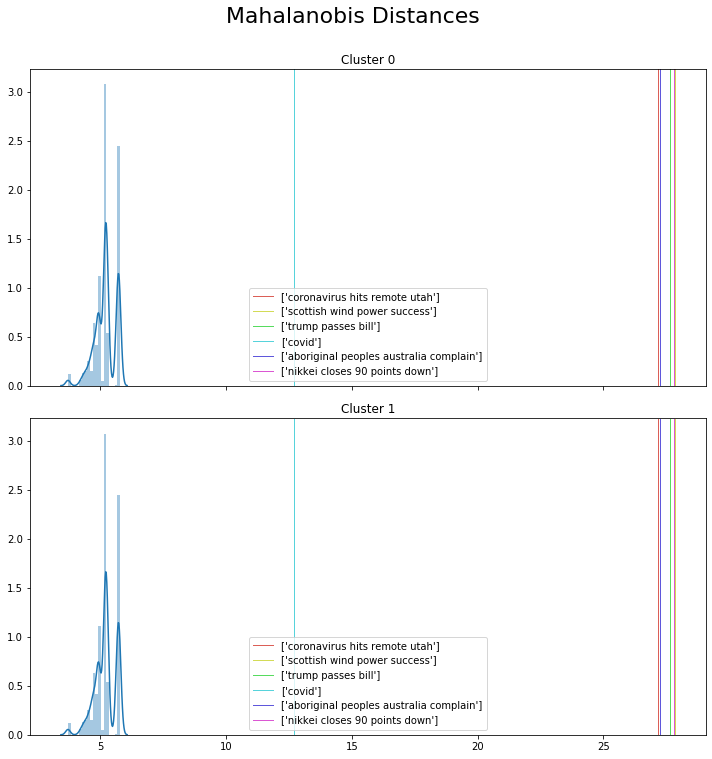

In [157]:
plot_words_on_dist(km_2, words)

In [20]:

def plot_words_on_dist(km, words):
    word_dist = other_k(km, words, func=np.log2)
    mydict, dist = calculate_distances(km)


    for i in dist["mh"]:
        dist["mh"][i] = [np.log2(j) for j in dist["mh"][i]]

    mh_dist = dist["mh"]

    cmap = seaborn.color_palette("hls", len(words))
    fig, axes = plt.subplots(len(mydict.keys()), 1, figsize=(10,10), sharex=True)

    for i, ax in enumerate(axes.flatten()):
        fig.add_subplot(ax)
        seaborn.distplot(mh_dist[i]).set_title("Cluster " + str(i))
        for idx, value in enumerate(word_dist):
            plt.axvline(value[i][1], c=cmap[idx], label=words[idx][0], linewidth=1)
        plt.legend()

    plt.xlabel("Natural Log of Mahalanobis distance from Cluster Centre")
    fig.tight_layout(w_pad=2)    
    fig.suptitle('Mahalanobis Distances from Cluster Centres for Clusters and Selected Phrases', fontsize=22, y=1.05)
    plt.savefig("words_kmeans_mahalanobis_distance_k=" + str(len(mydict.keys())) +  ".png")

In [ ]:
hist = plt.hist(dist["mh"][1])
plt.axvline(other_dist[1][1], color='k', linestyle='dashed', linewidth=1)
plt.show()

In [488]:
# https://stackoverflow.com/questions/27494202/how-do-i-visualize-data-points-of-tf-idf-vectors-for-kmeans-clustering

## Kmeans Word Cloud Cisualisation

In [21]:
def plot_word_cloud_kmeans(km, number_of_clusters, rows, columns, del_x=None, del_y=None):
    words = {}
    order_centroids = km.cluster_centers_.argsort()[:, ::-1]
    terms = vec.get_feature_names()
    for i in range(number_of_clusters):
        top_ten_words = [terms[ind] for ind in order_centroids[i, :10]]
        words[i] = top_ten_words
    
    centre_distances = {}
    for i in range(number_of_clusters):
        centre_distances[i] = [2 - i for i in np.sort(km.transform(matrix)[:,i])[:10]]
        
    for i in words:
        centre_distances[i] = list(zip(words[i], centre_distances[i]))
        
    cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)
    
    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
    fig, axes = plt.subplots(rows, columns, figsize=(10,10), sharex=True, sharey=True)

    for i, ax in enumerate(axes.flatten()):
        if i < number_of_clusters:
            fig.add_subplot(ax)
            cloud.generate_from_frequencies(dict(centre_distances[i]))
            plt.gca().imshow(cloud)
            plt.gca().set_title('Cluster ' + str(i), fontdict=dict(size=16))
            plt.gca().axis('off')

    if del_x is not None and del_y is not None:
        fig.delaxes(axes[del_x,del_y])
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.axis('off')
    plt.margins(x=0, y=0)
    plt.tight_layout()
    plt.savefig("kmeans_word_cloud_k=" +str(number_of_clusters)+ ".png")

### PCA T-SNE Visualisation

In [16]:
def pca_tsne(km, k, matrix):
    labels = km.predict(matrix)
    X = matrix.todense()
    cmap = cmap = ListedColormap(seaborn.color_palette("hls", k))
    labels_color_map = {
        0: '#20b2aa', 1: '#ff7373', 2: '#ffe4e1', 3: '#005073', 4: '#4d0404'
    }
    
    
    # pca 2 Dimensional
    pca_num_components = 2

    pca = PCA(n_components=pca_num_components)
    reduced_values = pca.fit_transform(X)
    eigenvalues = pca.explained_variance_     

    seaborn.scatterplot(
    x=reduced_values[:, 0], y=reduced_values[:, 1],
    hue=labels,
    palette=seaborn.color_palette("hls", k),
    legend="full",
    alpha=0.4
    )
    plt.xlabel("PCA Dimension 1\n Explained Variance: " + str(round(eigenvalues[0], 4)))
    plt.ylabel("PCA Dimension 2\n Explained Variance: " + str(round(eigenvalues[1], 4)))
    plt.title("2D PCA Plot for k=" + str(k))
    plt.savefig("kmeans_2d_pca_k=" + str(k) + ".png")
    plt.close()

    # T-sne 2 dimensional
    tsne_num_components = 2
    embeddings = TSNE(n_components=tsne_num_components)
    Y = embeddings.fit_transform(X)

    seaborn.scatterplot(
        x=Y[:, 0], y=Y[:, 1],
        hue=labels,
        palette=seaborn.color_palette("hls", k),
        legend="full",
        alpha=0.4
    )
    plt.title("2D T-SNE plot for k=" + str(k))
    plt.savefig("kmeans_2d_tsne_k=" + str(k) + ".png")
    
    # pca 3 Dimensional
    
    pca_num_components = 3
    pca = PCA(n_components=pca_num_components)
    reduced_values = pca.fit_transform(X)
    eigenvalues = pca.explained_variance_

    fig = plt.figure()
    axes = Axes3D(fig)
    axes.scatter(reduced_values[:,0], reduced_values[:,1], reduced_values[:,2], cmap=cmap, c=labels)

    pal = seaborn.color_palette("hls", k)  
    scatter = []
    cluster_labels = []
    for i in range(0,k):
        scatter.append(matplotlib.lines.Line2D([0],[0], linestyle="none", c=pal[i], marker = 'o'))
        cluster_labels.append("Cluster " + str(i))
    axes.set_xlabel("PCA Dimension 1\n Explained Variance: " + str(round(eigenvalues[0], 4)))
    axes.set_ylabel("PCA Dimension 2\n Explained Variance: " + str(round(eigenvalues[1], 4)))
    axes.set_zlabel("PCA Dimension 3\n Explained Variance: " + str(round(eigenvalues[2], 4)))
    plt.title("3D PCA Plot for k=" + str(k))
    axes.legend(scatter, cluster_labels, numpoints = 1)
    plt.savefig("kmeans_3d_pca_k=" + str(k) + ".png")

    # T-SNE 3 Dimensional
    
    tsne_num_components = 3
    embeddings = TSNE(n_components=tsne_num_components)
    Y = embeddings.fit_transform(X)
    pal = seaborn.color_palette("hls", k)
    
    fig = plt.figure()
    axes = Axes3D(fig)
    axes.scatter(Y[:,0], Y[:,1], Y[:,2], c=labels, cmap=cmap)

    scatter = []
    cluster_labels = []
    for i in range(0,k):
        scatter.append(matplotlib.lines.Line2D([0],[0], linestyle="none", c=pal[i], marker = 'o'))
        cluster_labels.append("Cluster " + str(i))
        
    axes.legend(scatter, cluster_labels, numpoints = 1)
    plt.title("3D T-SNE plot for k=" + str(k))
    plt.savefig("kmeans_3d_tsne_k=" + str(k) + ".png")

Individual PCA and T-SNE visualisation

In [17]:
pca_num_components = 2
X = matrix.todense()
pca = PCA(n_components=pca_num_components)
reduced_values = pca.fit_transform(X)
eigenvalues = pca.explained_variance_
eigenvalues

array([0.00902653, 0.00789112])

In [19]:
labels_color_map = {
    0: '#20b2aa', 1: '#ff7373', 2: '#ffe4e1'
}

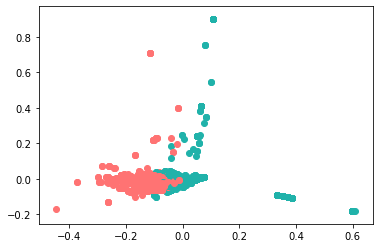

In [20]:
fig, ax = plt.subplots()
for index, instance in enumerate(reduced_values):
    pca_comp_1, pca_comp_2 = reduced_values[index]
    color = labels_color_map[labels[index]]
    ax.scatter(pca_comp_1, pca_comp_2, c=color)
plt.show()

In [21]:
tsne_num_components = 2
embeddings = TSNE(n_components=tsne_num_components)
Y = embeddings.fit_transform(X)

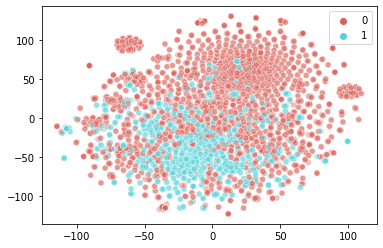

In [22]:
seaborn.scatterplot(
    x=Y[:, 0], y=Y[:, 1],
    hue=labels,
    palette=seaborn.color_palette("hls", 2),
    legend="full",
    alpha=0.4
)

### 3D PCA

In [28]:
pca_num_components = 3
X = matrix.todense()
pca = PCA(n_components=pca_num_components)
reduced_values = pca.fit_transform(X)
eigenvalues = pca.explained_variance_
eigenvalues

array([0.00902652, 0.00789118, 0.00748842])

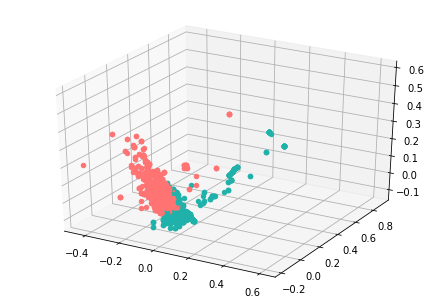

In [45]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
axes = Axes3D(fig)

for index, instance in enumerate(reduced_values):
    pca_comp_1, pca_comp_2, pca_comp_3 = reduced_values[index]
    color = labels_color_map[labels[index]]
    axes.scatter(pca_comp_1, pca_comp_2, pca_comp_3, c=color)
plt.show()

In [30]:
tsne_num_components = 3
embeddings = TSNE(n_components=tsne_num_components)
Y = embeddings.fit_transform(X)

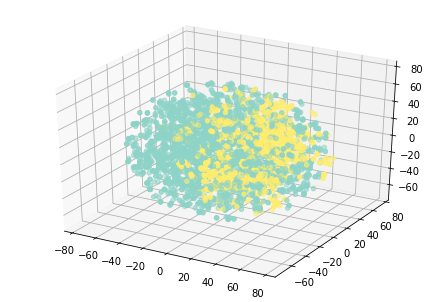

In [44]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
axes = Axes3D(fig)

axes.scatter(Y[:,0], Y[:,1], Y[:,2], c=labels, cmap=plt.get_cmap("Set3"))
plt.show()

# Stock and Goldstein/Tone Data

## GoldStein Score

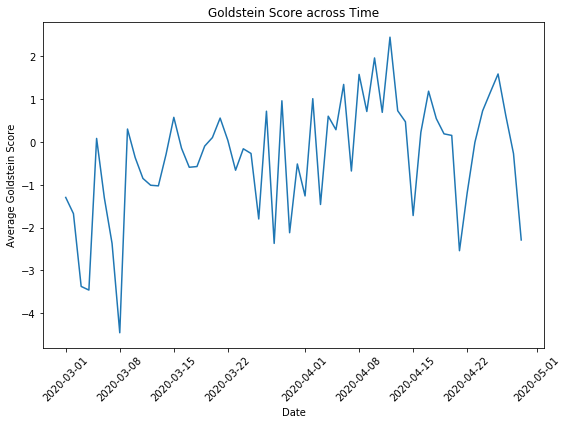

In [39]:
new_data = us_chn_data.groupby('SQLDATE', as_index=False, sort=False)['GoldsteinScale'].mean()
format_str = '%Y%m%d'
new_data.SQLDATE = [datetime.strptime(str(x), format_str) for x in new_data.SQLDATE]
goldstein = new_data[new_data.SQLDATE > datetime(2020,2,29)].sort_values(by="SQLDATE")
fig, axes = plt.subplots(1, 1, figsize=(8,6))
plt.plot(goldstein.SQLDATE, goldstein.GoldsteinScale)
plt.xticks(rotation=45)
plt.xlabel("Date")
plt.ylabel("Average Goldstein Score")
plt.title("Goldstein Score across Time")
plt.tight_layout()
plt.savefig("goldsteinscore.png")

Take a 3 day average

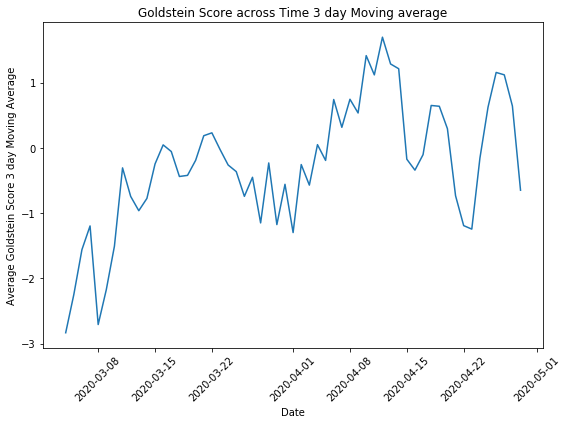

In [40]:
k=3
nd = goldstein.copy()
nd["mean"] = goldstein.rolling(k).mean()
fig, axes = plt.subplots(1, 1, figsize=(8,6))
plt.plot(nd["SQLDATE"][k:], nd["mean"][k:])
plt.xticks(rotation=45)
plt.xlabel("Date")
plt.ylabel("Average Goldstein Score 3 day Moving Average")
plt.title("Goldstein Score across Time 3 day Moving average")
plt.tight_layout()
plt.savefig("goldsteinscore_ma.png")

## Average Tone

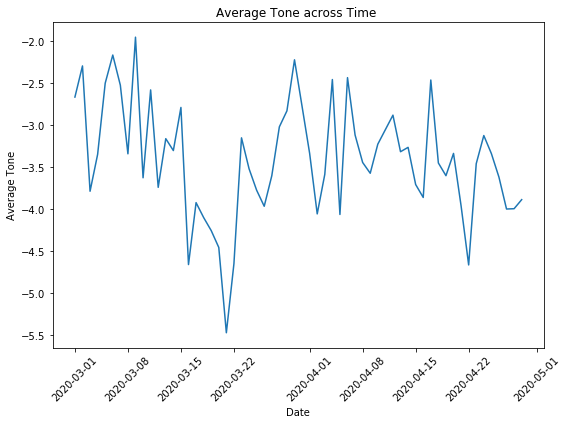

In [41]:
new_data = us_chn_data.groupby('SQLDATE', as_index=False, sort=False)['AvgTone'].mean()

format_str = '%Y%m%d' # The format
new_data.SQLDATE = [datetime.strptime(str(x), format_str) for x in new_data.SQLDATE]

tone = new_data[new_data.SQLDATE > datetime(2020,2,29)].sort_values(by="SQLDATE")

fig, axes = plt.subplots(1, 1, figsize=(8,6))
plt.plot(tone.SQLDATE, tone.AvgTone)

plt.xticks(rotation=45)
plt.xlabel("Date")
plt.ylabel("Average Tone")
plt.title("Average Tone across Time ")
plt.tight_layout()
plt.savefig("avgtone.png")

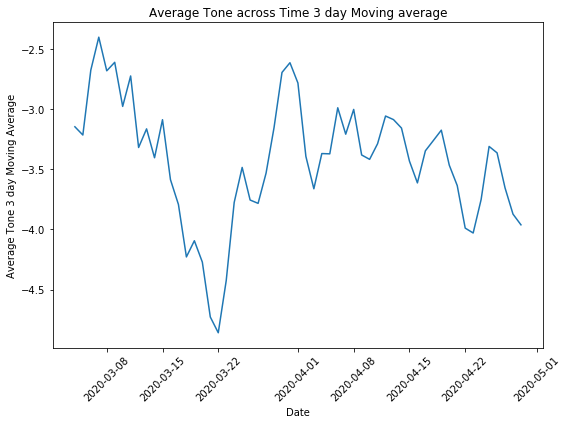

In [42]:
k=3
nd = tone.copy()
nd["mean"] = tone.rolling(k).mean()
fig, axes = plt.subplots(1, 1, figsize=(8,6))
plt.plot(nd["SQLDATE"][k:], nd["mean"][k:])
plt.xticks(rotation=45)
plt.xlabel("Date")
plt.ylabel("Average Tone 3 day Moving Average")
plt.title("Average Tone across Time 3 day Moving average")
plt.tight_layout()
plt.savefig("avgtone_ma.png")

## Dow Jones

WGET python query 

In [314]:
url = "https://query1.finance.yahoo.com/v7/finance/download/%5EDJI?period1=1583020800&period2=1588204800&interval=1d&events=history"

In [315]:
filename = requests.get(url)

In [316]:
f= open('./dow.csv', 'wb')
f.write(filename.content)
f.close()

In [19]:
dow = pd.read_csv("dow.csv")

In [20]:
dow["Diff"] = dow["Open"] - dow["Close"]

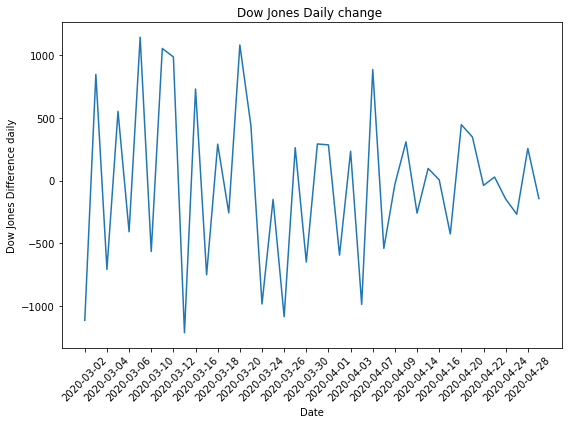

In [32]:
fig, axes = plt.subplots(1, 1, figsize=(8,6))
plt.plot(dow["Date"], dow["Diff"])
plt.xticks(rotation=45)
axes.set_xticks(axes.get_xticks()[::2])
plt.xlabel("Date")
plt.ylabel("Dow Jones Difference daily")
plt.title("Dow Jones Daily change ")
plt.tight_layout()
plt.savefig("dow_diff.png")

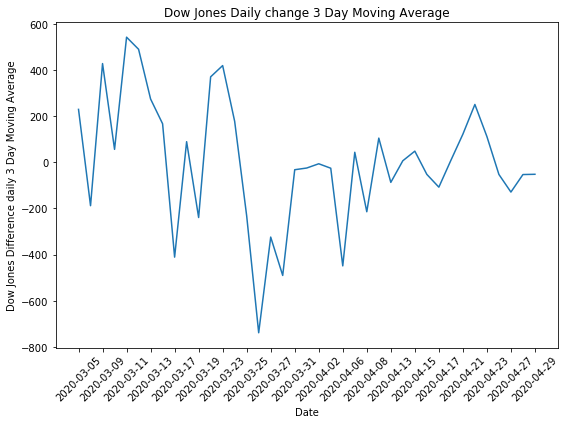

In [33]:
k=3 
nd = dow.copy()
nd["mean"] = dow["Diff"].rolling(k).mean()
fig, axes = plt.subplots(1, 1, figsize=(8,6))
plt.plot(nd["Date"][k:], nd["mean"][k:])
plt.xticks(rotation=45)
axes.set_xticks(axes.get_xticks()[::2])
plt.xlabel("Date")
plt.ylabel("Dow Jones Difference daily 3 Day Moving Average")
plt.title("Dow Jones Daily change 3 Day Moving Average")
plt.tight_layout()
plt.savefig("dow_diff_ma.png")

### Initial extrapolation attempt

Initially rather than condensing the weekend news data into weekday, the approach was to extrapolate the results of the stock data, this approach was abandoned in favour of the former approach, but the code is left

In [321]:
date_data_frame = pd.DataFrame()

In [322]:
date_data_frame["Date"] = pd.date_range(pd.to_datetime("2020/03/01"), periods=61).tolist()

In [323]:
dow["Date"] = pd.to_datetime(dow["Date"])

In [324]:
dow

Date          Open          High           Low         Close  \
0  2020-03-02  25590.509766  26706.169922  25391.960938  26703.320313   
1  2020-03-03  26762.470703  27084.589844  25706.279297  25917.410156   
2  2020-03-04  26383.679688  27102.339844  26286.310547  27090.859375   
3  2020-03-05  26671.919922  26671.919922  25943.330078  26121.279297   
4  2020-03-06  25457.210938  25994.380859  25226.619141  25864.779297   
5  2020-03-09  24992.359375  24992.359375  23706.070313  23851.019531   
6  2020-03-10  24453.000000  25020.990234  23690.339844  25018.160156   
7  2020-03-11  24604.630859  24604.630859  23328.320313  23553.220703   
8  2020-03-12  22184.710938  22837.949219  21154.460938  21200.619141   
9  2020-03-13  21973.820313  23189.759766  21285.369141  23185.619141   
10 2020-03-16  20917.529297  21768.279297  20116.460938  20188.519531   
11 2020-03-17  20487.050781  21379.349609  19882.259766  21237.380859   
12 2020-03-18  20188.689453  20489.330078  18917.460938  19898.919922   
13 2020-03-19  19830.009766  20442.630859  19177.130859  20087.189453   
14 2020-03-20  20253.150391  20531.259766  19094.269531  19173.980469   
15 2020-03-23  19028.359375  19121.009766  18213.650391  18591.929688   
16 2020-03-24  19722.189453  20737.699219  19649.250000  20704.910156   
17 2020-03-25  21050.339844  22019.929688  20538.339844  21200.550781   
18 2020-03-26  21468.380859  22595.060547  21427.099609  22552.169922   
19 2020-03-27  21898.470703  22327.570313  21469.269531  21636.779297   
20 2020-03-30  21678.220703  22378.089844  21522.080078  22327.480469   
21 2020-03-31  22208.419922  22480.369141  21852.080078  21917.160156   
22 2020-04-01  21227.380859  21487.240234  20784.429688  20943.509766   
23 2020-04-02  20819.460938  21477.769531  20735.019531  21413.439453   
24 2020-04-03  21285.929688  21447.810547  20863.089844  21052.529297   
25 2020-04-06  21693.630859  22783.449219  21693.630859  22679.990234   
26 2020-04-07  23537.439453  23617.240234  22634.449219  22653.859375   
27 2020-04-08  22893.470703  23513.400391  22682.990234  23433.570313   
28 2020-04-09  23690.660156  24008.990234  23504.089844  23719.369141   
29 2020-04-13  23698.929688  23698.929688  23095.349609  23390.769531   
30 2020-04-14  23690.570313  24040.580078  23683.439453  23949.759766   
31 2020-04-15  23600.720703  23649.720703  23233.320313  23504.349609   
32 2020-04-16  23543.660156  23598.080078  23211.380859  23537.679688   
33 2020-04-17  23817.150391  24264.210938  23817.150391  24242.490234   
34 2020-04-20  24095.099609  24108.689453  23627.189453  23650.439453   
35 2020-04-21  23365.250000  23365.250000  22941.880859  23018.880859   
36 2020-04-22  23437.339844  23613.099609  23339.599609  23475.820313   
37 2020-04-23  23543.089844  23885.359375  23483.349609  23515.259766   
38 2020-04-24  23628.240234  23826.000000  23417.679688  23775.269531   
39 2020-04-27  23866.150391  24207.650391  23840.609375  24133.779297   
40 2020-04-28  24357.169922  24512.240234  24031.199219  24101.550781   
41 2020-04-29  24490.369141  24764.769531  24453.990234  24633.859375   

       Adj Close     Volume         Diff  
0   26703.320313  637200000 -1112.810547  
1   25917.410156  647080000   845.060547  
2   27090.859375  457590000  -707.179687  
3   26121.279297  477370000   550.640625  
4   25864.779297  599780000  -407.568359  
5   23851.019531  750430000  1141.339844  
6   25018.160156  654860000  -565.160156  
7   23553.220703  663960000  1051.410156  
8   21200.619141  908260000   984.091797  
9   23185.619141  843080000 -1211.798828  
10  20188.519531  770130000   729.009766  
11  21237.380859  793060000  -750.330078  
12  19898.919922  871360000   289.769531  
13  20087.189453  780300000  -257.179687  
14  19173.980469  872290000  1079.169922  
15  18591.929688  787970000   436.429687  
16  20704.910156  799340000  -982.720703  
17  21200.550781  796320000  -150.210937  
18  22552.169922  705180000 -1083.789063  
19  21636

In [325]:
fin_df = pd.merge(date_data_frame, dow, "left", on="Date")

In [326]:
fin_df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Diff'], dtype='object')

In [327]:
fin_df.drop(["High", "Low", "Adj Close", "Volume"], axis=1, inplace=True)

In [328]:
fin_df.dtypes

Date     datetime64[ns]
Open            float64
Close           float64
Diff            float64
dtype: object

In [329]:
fin_df

Date          Open         Close         Diff
0  2020-03-01           NaN           NaN          NaN
1  2020-03-02  25590.509766  26703.320313 -1112.810547
2  2020-03-03  26762.470703  25917.410156   845.060547
3  2020-03-04  26383.679688  27090.859375  -707.179687
4  2020-03-05  26671.919922  26121.279297   550.640625
..        ...           ...           ...          ...
56 2020-04-26           NaN           NaN          NaN
57 2020-04-27  23866.150391  24133.779297  -267.628906
58 2020-04-28  24357.169922  24101.550781   255.619141
59 2020-04-29  24490.369141  24633.859375  -143.490234
60 2020-04-30           NaN           NaN          NaN

[61 rows x 4 columns]

In [330]:
fin_df.set_index('Date', inplace=True)

In [331]:
int_dow = fin_df.interpolate(method='linear', limit_direction='both')

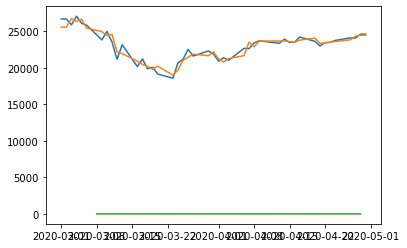

In [335]:
plt.plot(int_dow.index, int_dow.Close)
plt.plot(int_dow.index, int_dow.Open)

k=7 
nd = goldstein.copy()
nd["mean"] = goldstein.rolling(k).mean()
plt.plot(nd["SQLDATE"][k:], nd["mean"][k:])

In [88]:
plt.plot(int_dow.index, int_dow.Diff)
plt.xticks(rotation=45)
plt.xlabel("Date")
plt.ylabel("Dow Jones Difference daily")
plt.title("Dow Jones Daily change ")
plt.savefig("dow_diff.png")

NameError: name 'int_dow' is not defined

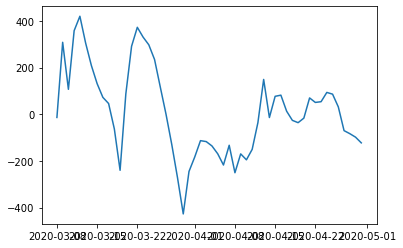

In [339]:
k=7
nd = int_dow.copy()
nd["Diff_copy"] = int_dow.Diff.rolling(k).mean()
plt.plot(nd.index[k:], nd["Diff_copy"][k:])

In [341]:
merged = pd.merge(pd.merge(tone, goldstein, "inner", "SQLDATE"), int_dow, right_index=True, left_on='SQLDATE')

## Initial attempt to parse an entire article instead of just a headline

In [75]:

# Single 15 minute interval pull, output to json format with mentions table
results = gd2.Search(['2019 Nov 1'],table='mentions', coverage=True)
print(len(results))

448157


In [76]:
results

GLOBALEVENTID   EventTimeDate  MentionTimeDate  MentionType  \
0           883657799  20191101020000   20191101040000            1   
1           883657800  20191101020000   20191101040000            1   
2           883657801  20191101020000   20191101040000            1   
3           883669697  20191101033000   20191101040000            1   
4           883672640  20191101040000   20191101040000            1   
...               ...             ...              ...          ...   
448152      883824027  20191101203000   20191101231500            1   
448153      883848133  20191101231500   20191101231500            1   
448154      883848134  20191101231500   20191101231500            1   
448155      883848135  20191101231500   20191101231500            1   
448156      883848136  20191101231500   20191101231500            1   

            MentionSourceName  \
0               brudirect.com   
1               brudirect.com   
2               brudirect.com   
3                     msn.com   
4                 guardian.ng   
...                       ...   
448152      guernseypress.com   
448153      newschannel10.com   
448154               kcbd.com   
448155  americanmachinist.com   
448156  americanmachinist.com   

                                        MentionIdentifier  SentenceID  \
0                 https://brudirect.com/news.php?id=79831           2   
1                 https://brudirect.com/news.php?id=79831           2   
2                 https://brudirect.com/news.php?id=79831           2   
3       https://www.msn.com/en-ca/finance/topstories/c...          14   
4       https://guardian.ng/business-services/what-bre...          11   
...                                                   ...         ...   
448152  https://guernseypress.com/news/uk-news/2019/11...           2   
448153  https://www.newschannel10.com/2019/11/01/clovi...           4   
448154  https://www.kcbd.com/2019/11/01/clovis-man-get...           2   
448155  https://www.americanmachinist.com/machining-cu...           1   
448156  https://www.americanmachinist.com/machining-cu...           1   

        Actor1CharOffset  Actor2CharOffset  ActionCharOffset  InRawText  \
0                    547               696               621          1   
1                    547               696               621          0   
2                    547               696               728          1   
3                   3816              3870              3865          1   
4                   4616              4660              4644          0   
...                  ...               ...               ...        ...   
448152               415                -1               380          1   
448153               626                -1               688          1   
448154               382               390               408          0   
448155              1761                -1              1823          1   
448156              1761              1781              1834          0   

        Confidence  MentionDocLen  MentionDocTone  MentionDocTranslationInfo  \
0               40           2037        2.339181                        NaN   
1               60           2037        2.339181                        NaN   
2              100           2037        2.339181                        NaN   
3              100           4381        0.137741                        NaN   
4               10           5414       -2.505695                        NaN   
...            ...            ...             ...                        ...   
448152          60           3085        0.198413                        NaN   
448153          30           1865       -8.722741                        NaN   
448154          20           2388       -7.323232                        NaN   
448155          30           3879        0.972447                        NaN   
448156          10           3879        0.972447                        NaN   

        Extras  
0 

In [ ]:
filtered_words = [word for word in functools.reduce(operator.iconcat, filt_list_of_things, []) if word not in stopwords.words('english')]

In [41]:
import requests
from bs4 import BeautifulSoup

In [25]:
results2["SOURCEURL"][0]

'https://www.theprogress.com/news/after-blackface-scandal-trudeau-shuns-photo-ops-of-trick-or-treating/'

In [32]:

for i in range(0,100):
    ret = requests.get(results2["SOURCEURL"][i])
    if ret.status_code == 200:
        break;



In [52]:
ret.url

'https://www.tnp.sg/news/singapore/scdf-ragging-death-warrant-officer-third-person-be-convicted'

In [37]:
ret.content

b'<!DOCTYPE html>\n<html lang="en" dir="ltr" prefix="og: http://ogp.me/ns# article: http://ogp.me/ns/article# book: http://ogp.me/ns/book# profile: http://ogp.me/ns/profile# video: http://ogp.me/ns/video# product: http://ogp.me/ns/product# content: http://purl.org/rss/1.0/modules/content/ dc: http://purl.org/dc/terms/ foaf: http://xmlns.com/foaf/0.1/ rdfs: http://www.w3.org/2000/01/rdf-schema# sioc: http://rdfs.org/sioc/ns# sioct: http://rdfs.org/sioc/types# skos: http://www.w3.org/2004/02/skos/core# xsd: http://www.w3.org/2001/XMLSchema# schema: http://schema.org/">\n<head>\n  <link rel="profile" href="http://www.w3.org/1999/xhtml/vocab" />\n  <meta charset="utf-8">\n  <meta http-equiv="X-UA-Compatible" content="IE=edge">\n  <meta name="viewport" content="width=device-width, initial-scale=1.0, maximum-scale=1.0, user-scalable=no">\n  <link rel="apple-touch-icon" sizes="180x180" href="/apple-touch-icon.png">\n  <link rel="icon" type="image/png" href="/favicon-32x32.png" sizes="32x32">\

In [55]:
import html5lib

In [57]:
soup1 = BeautifulSoup(ret.content, "html.parser")

In [58]:
headline = soup1.find_all('h2', )

In [60]:
headline

[<h2 class="block-title">Popular</h2>,
 <h2 class="card-title"><a href="https://www.tnp.sg/news/singapore/youth-who-was-popular-girls-was-sexual-predator">Sexual predator gets 22 years' jail and 24 strokes for preying on 19 victims, including minors</a></h2>,
 <h2 class="card-title"><a href="https://www.tnp.sg/news/singapore/scdf-ragging-death-officers-argued-over-push">SCDF ragging death: Officers argued over push</a></h2>,
 <h2 class="byline-name"><a href="/author/shaffiq-alkhatib">Shaffiq Alkhatib</a></h2>,
 <h2 class="card-title"><a href="https://www.tnp.sg/news/singapore/nus-students-get-zero-marks-cheating-take-home-exam">NUS students get zero for cheating on take-home exam</a></h2>,
 <h2 class="card-title"><a href="https://www.tnp.sg/news/singapore/man-63-fined-3500-meeting-friends-drink-beer-public">Man, 63, fined $3,500 for meeting friends to drink beer</a></h2>,
 <h2 class="card-title"><a href="https://www.tnp.sg/news/singapore/fishmonger-spits-mutton-seller-tekka-market-frac

## Initial TFIDF example run on a sample article

text from: https://www.cnbc.com/2020/06/09/us-china-tensions-over-coronavirus-scrutiny-on-chinese-firms-in-financial-markets.html

In [142]:
text = "The U.S.-China ‘cold war’ is here — and Beijing may start targeting Washington’s allies, analysts say From a trade fight to a war of words over the origin of the coronavirus, to greater scrutiny of Chinese firms on Wall Street — relations between the U.S. and China have nosedived in recent years. A new “cold war” is here and things could get uglier as other countries get dragged into the conflict, analysts warn. “Things will get worse — perhaps much worse — before they get better. Decoupling is underway,” said Dan Ikenson, director of the Herbert A. Stiefel Center for Trade Policy Studies at the Cato Institute, referring to an economic split between the world’s two largest economies. Beijing could also start targeting America’s allies, as it embarks on what analysts call the “wolf warrior diplomacy.” It is named after a series of hugely-popular movies where Chinese fighters defeat adversaries globally. Most recently, the situation escalated after China proposed a new security law for Hong Kong, a semi-autonomous Chinese territory that has a special trading relationship with the U.S. President Donald Trump swiftly announced that the U.S. will revoke the city’s preferential status. “Hong Kong is no longer sufficiently autonomous to warrant the special treatment that we have afforded the territory” since the former British colony was returned to China in 1997, he said. China does not want to get into a full-scale confrontation with the US at the present time. It wants to concentrate on containing the virus, reviving the economy and pushing through the security law in Hong Kong. U.S.-China relations have been strained since 2018, when the two countries were embroiled in a protracted trade war — which dragged down global growth and culminated in a phase one deal that was signed in January. Their rocky relations started up again early this year, when U.S. President Donald Trump blamed China for the spread of the coronavirus pandemic. Recently, tensions moved to the financial markets. The U.S. Senate passed legislation last month that could restrict Chinese companies from listing on American exchanges or raising money from investors on Wall Street, unless they abide by Washington’s regulatory and audit standards. “Many economic redundancies will emerge as the United States and China replicate efforts and compete for the allegiances of the rest of the world by offering carrots and threatening sticks,” Ikenson said. “That is what is meant by the emergence of a new cold war environment.” Beijing’s ‘wolf diplomacy’ Beijing could use the relatively new strategy, termed “wolf warrior diplomacy” by some analysts, to hit out at those perceived to be on Washington’s side. Christopher Granville from research firm TS Lombard, calls the recent uptick in tensions “Cold War 2.0,” said some U.S. allies might be “repaid with ‘wolf diplomacy’ for perceived affronts to the legitimacy of the Chinese system.” Some of those tactics are already playing out, Granville said in a note. For instance, China suspended some beef imports from Australia after the latter called for a global enquiry into the origins of the coronavirus. ″‘Wolf Warrior diplomacy’ is China’s new no-holds-barred approach to the outside world,” added Edward Lucas of the Center for European Policy Analysis in a note last month. He added: “The backlash against Wolf Warrior diplomacy is growing. China has stoked anger in Australia, Canada, Germany, the Netherlands, and Sweden — to take just a few recent examples.” Just last Friday, Beijing advised its citizens not to travel to Australia, saying there’s racial discrimination and violence against the Chinese in relation to the pandemic. Australia has disputed that, according to Reuters. Elsewhere, the United Kingdom could also find itself on the receiving end of China’s wrath after Britain offered visa options to the Hong Kong people following concerns that China was tightening its grip on the city, Granville added. No full-blown confrontation for now It’s in neither party’s interest to bring their so-called cold war too far at this point, however, say analysts. Beijing will probably limit itself to “a combination of more neutral tit-for-tat and veiled warnings,” said TS Lombard. “While it will react rhetorically, China does not want to get into a full-scale confrontation with the US at the present time. It wants to concentrate on containing the virus, reviving the economy and pushing through the security law in Hong Kong,” Jonathan Fenby of TS Lombard told CNBC in an email. 'Relations with the US have some influence on these issues but are not the main concern right now.' On the part of the U.S., while Trump would likely seek to maximize anti-China sentiment during his presidential campaign, he too may restrain himself ultimately Undoubtedly, the resulting political gains from 'China-bashing' will come at a lower economic cost, at a time when the stock market is strong, said Granville of TS Lombard. Still, 'Trump will remain vigilant about containing that economic cost since the practical effects of unbridled escalation on China – from reduced farm incomes to tanking markets – would outweigh the favourable 'tough guy' impression on his voter base,' he wrote. However, the Trump administration is not likely going to be the only one targeting China. 'There seems to be broad bipartisan support for this new dispensation, which means things probably won’t change much under a Biden administration,' said Cato Institute’s Ikenson, referring to the possibility of a new administration under former U.S. Vice President Joe Biden, who has formally secured a Democratic presidential nomination. Former Singapore senior diplomat Bilahari Kausikan, however, told CNBC last week that he doesn’t think both countries are 'on an inevitable collision course.' 'People forget one big factor — and that’s the nuclear factor. There is a state of nuclear deterrence, and that makes war by design highly improbable,' said Kausikan, dismissing outright conflict between the two world powers. 'Doesn’t mean it cannot happen by accident, but it is improbable,' said Kausikan, who was formerly Singapore’s Permanent Representative to the United Nations, and previously served as permanent secretary at the Ministry of Foreign Affairs in Singapore."

In [143]:
del string

In [144]:
fin_string = re.sub(r'[^\w\s]','',text)

In [146]:
vectorizer = TfidfVectorizer(stop_words=stop_words)
vectors = vectorizer.fit_transform([fin_string])
feature_names = vectorizer.get_feature_names()
dense = vectors.todense()
denselist = dense.tolist()
df = pd.DataFrame(denselist, columns=feature_names)
new_df = df.transpose()
new_df.columns = ["TF/IDF"]
new_df.sort_values("TF/IDF", ascending=False)

TF/IDF
china     0.295778
us        0.271130
said      0.246482
war       0.197186
new       0.172537
...            ...
greater   0.024648
going     0.024648
globally  0.024648
germany   0.024648
years     0.024648

[392 rows x 1 columns]